# Replicating IMF Paper: Objectives & Overview
This notebook reconstructs key analyses from the added IMF paper. It provides:
- Canonical IMF functional forms (Salpeter, Kroupa, Chabrier, Custom)
- Normalization and integration routines
- Parameter fitting scaffolding (frequentist & Bayesian placeholders)
- Sampling & sensitivity analyses
- Derived quantities: mass fractions, number fractions, remnant & recycle estimates, mass-to-light impacts
- Exports of tables and figures for reproducibility.

Assumptions:
- Stellar mass range: 0.08–120 Msun (adjustable)
- Units: IMF \(\xi(m) = dN/dM\)
- Normalization: default sets total initial stellar mass = 1 Msun when integrated over range unless stated otherwise.
- If observational catalogs or SED libraries are missing, placeholder stubs are used.

Citations (insert actual references from your paper text): Salpeter (1955), Kroupa (2001), Chabrier (2003).


In [6]:
# Add package to path
import sys
from pathlib import Path
from typing import Callable, Dict

# 1. Imports and Global Configuration
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree

project_root = Path.cwd().parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

# Optional / guarded imports
try:
    from scipy import integrate, optimize, stats
except Exception:
    integrate = None
    optimize = None
    stats = None
try:
    import pymc as pm
except Exception:
    pm = None
try:
    import fsps
except Exception:
    fsps = None
try:
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.decomposition import PCA
    import arviz as az
except Exception:
    GaussianProcessRegressor = None
    Matern = None
    C = None
    RandomForestRegressor = None
    PCA = None
    az = None

sns.set_context('talk')
plt.rcParams.update({'figure.figsize':(8,6),'axes.grid':True,'grid.alpha':0.25})

# Output directories: images and tabular data
DATA_DIR = 'plots/_plots_data/imf_replication'
IMAGES_DIR = 'plots/imf_replication'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
# Backward-compat alias for existing code writing data
RESULTS_DIR = DATA_DIR

# Redirect matplotlib savefig to IMAGES_DIR when target is a figure
_original_savefig = plt.savefig

def _savefig_wrapper(*args, **kwargs):
    # Determine target path
    fname = None
    if args and isinstance(args[0], str):
        fname = args[0]
    elif isinstance(kwargs.get('fname', None), str):
        fname = kwargs['fname']
    # If no filename string, defer to original
    if not isinstance(fname, str):
        return _original_savefig(*args, **kwargs)
    # Normalize
    base = os.path.basename(fname)
    ext = os.path.splitext(base)[1].lower()
    # Only redirect typical image extensions
    image_exts = {'.png', '.jpg', '.jpeg', '.svg', '.pdf'}
    if ext in image_exts:
        # If path is just a basename or points into DATA_DIR, rewrite to IMAGES_DIR
        if (base == fname) or fname.startswith(DATA_DIR):
            new_path = os.path.join(IMAGES_DIR, base)
            if args and isinstance(args[0], str):
                args = (new_path,) + tuple(args[1:])
            else:
                kwargs['fname'] = new_path
    return _original_savefig(*args, **kwargs)

plt.savefig = _savefig_wrapper

M_MIN, M_MAX = 0.08, 120.0  # Msun

In [7]:
# 2. Load / Ingest Paper Data Sources (Placeholders)
# In the absence of actual observational data tables from the paper, we create stubs.
# Replace `load_observed_counts()` with real file readers (CSV, FITS, etc.) when available.

def load_observed_counts():
    """Return synthetic binned stellar counts (mass_mid, N_obs, sigma_N).
    Placeholder: draws from a reference IMF (Salpeter) with sampling noise."""
    mass_edges = np.logspace(np.log10(0.1), np.log10(50), 20)
    mass_mid = 10**(0.5*(np.log10(mass_edges[:-1])+np.log10(mass_edges[1:])))
    alpha = 2.35
    # Salpeter shape (unnormalized) dN/dM ~ M^-alpha
    dNdM = mass_mid**(-alpha)
    # Convert to counts per bin (approx) with arbitrary normalization
    counts = dNdM * np.diff(mass_edges)
    # Add Poisson noise
    N_obs = np.random.poisson(lam=np.clip(counts*5e3, 5, None))
    sigma_N = np.sqrt(N_obs)
    return pd.DataFrame({'mass_mid':mass_mid,'N_obs':N_obs,'sigma_N':sigma_N})

try:
    observed_df = load_observed_counts()
except Exception as e:
    print('Failed to load observed counts:', e)
    observed_df = None

observed_df.head() if observed_df is not None else None


,mass_mid,N_obs,sigma_N
0,0.117768,29539,171.869136
1,0.163334,18721,136.824705
2,0.226531,12291,110.864783
3,0.314180,7774,88.170290
4,0.435742,5107,71.463277


In [8]:
# 3. Preprocess Observational Catalogs (Quality Cuts, Binning)
# For placeholder data we just ensure positive counts and build normalized frequencies.
if observed_df is not None:
    obs = observed_df.copy()
    obs = obs[obs['N_obs'] > 0]
    total_counts = obs['N_obs'].sum()
    obs['freq'] = obs['N_obs'] / total_counts
    # Cumulative number fraction
    obs = obs.sort_values('mass_mid')
    obs['cum_number_frac'] = np.cumsum(obs['N_obs']) / total_counts
else:
    obs = None

obs.head() if obs is not None else None


,mass_mid,N_obs,sigma_N,freq,cum_number_frac
0,0.117768,29539,171.869136,0.357797,0.357797
1,0.163334,18721,136.824705,0.226762,0.584559
2,0.226531,12291,110.864783,0.148877,0.733436
3,0.314180,7774,88.170290,0.094164,0.827600
4,0.435742,5107,71.463277,0.061860,0.889460


In [9]:
# 4. Define IMF Functional Forms (Salpeter, Kroupa, Chabrier, Custom)

class IMF:
    def __init__(self, name: str, func: Callable[[np.ndarray], np.ndarray], mass_range=(M_MIN,M_MAX)):
        self.name = name
        self.func = func  # unnormalized dN/dM
        self.mass_range = mass_range
        self.norm_const_number = None
        self.norm_const_mass = None

    def dndm(self, m):
        return self.func(np.asarray(m))

    def normalize(self, mode='mass'):
        m1,m2 = self.mass_range
        m_grid = np.logspace(np.log10(m1), np.log10(m2), 5000)
        dndm_raw = self.func(m_grid)
        dm = np.diff(m_grid)
        m_mid = 0.5*(m_grid[:-1]+m_grid[1:])
        if mode=='number':
            total = np.sum(dndm_raw[:-1]*dm)
            A = 1.0/total
            self.norm_const_number = A
            return A
        elif mode=='mass':
            total_mass = np.sum(dndm_raw[:-1]*m_mid*dm)
            A = 1.0/total_mass
            self.norm_const_mass = A
            return A
        else:
            raise ValueError('mode must be number or mass')

    def dndm_norm(self, m, mode='mass'):
        if mode=='mass' and self.norm_const_mass is None:
            self.normalize('mass')
        if mode=='number' and self.norm_const_number is None:
            self.normalize('number')
        A = self.norm_const_mass if mode=='mass' else self.norm_const_number
        return A*self.dndm(m)

# Salpeter IMF
SALPETER_ALPHA = 2.35
salpeter = IMF('Salpeter', lambda m: m**(-SALPETER_ALPHA))

# Kroupa (2001) piecewise slopes
# Slopes: alpha1=1.3 (0.08-0.5), alpha2=2.3 (>0.5)

def kroupa_piecewise(m):
    m = np.asarray(m)
    out = np.zeros_like(m)
    mask1 = (m>=0.08) & (m<0.5)
    mask2 = (m>=0.5)
    out[mask1] = m[mask1]**(-1.3)
    out[mask2] = (0.5**(-1.3)) * (m[mask2]/0.5)**(-2.3)  # ensure continuity
    return out
kroupa = IMF('Kroupa', kroupa_piecewise)

# Chabrier (2003): lognormal below 1 Msun, power law above.
# Parameters typical: m_c=0.22 Msun, sigma=0.57, alpha=2.3 above 1 Msun.
CHAB_M_C, CHAB_SIGMA, CHAB_ALPHA = 0.22, 0.57, 2.3

def chabrier(m):
    m = np.asarray(m)
    out = np.zeros_like(m)
    mask_low = (m<=1.0)
    mask_high = (m>1.0)
    out[mask_low] = (1.0/m[mask_low]) * np.exp(- (np.log10(m[mask_low]) - np.log10(CHAB_M_C))**2 / (2*CHAB_SIGMA**2))
    # continuity constant at 1 Msun
    A_high = out[mask_low & (np.isclose(m,1.0))]
    if A_high.size==0:
        # evaluate low part at 1 Msun
        A_high = (1.0/1.0)*np.exp(- (np.log10(1.0) - np.log10(CHAB_M_C))**2 /(2*CHAB_SIGMA**2))
    out[mask_high] = A_high * (m[mask_high])**(-CHAB_ALPHA)
    return out
chabrier_imf = IMF('Chabrier', chabrier)

IMFS = [salpeter, kroupa, chabrier_imf]
for imf in IMFS:
    imf.normalize('mass')

# Custom IMF placeholder: user can inject slopes/breaks via a dict.
def custom_broken_powerlaw(slopes: Dict[str,float], breaks: Dict[str,float]):
    # slopes keys: s1,s2,... ; breaks sorted ascending excluding M_MIN & M_MAX
    b_sorted = sorted([b for b in breaks.values()])
    seg_edges = [M_MIN] + b_sorted + [M_MAX]
    seg_slopes = [slopes[k] for k in sorted(slopes.keys())]
    def _f(m):
        m = np.asarray(m)
        out = np.zeros_like(m)
        for i in range(len(seg_slopes)):
            lo, hi = seg_edges[i], seg_edges[i+1]
            mask = (m>=lo) & (m<hi) if i < len(seg_slopes)-1 else (m>=lo) & (m<=hi)
            # continuity: compute normalization relative to first segment
            if i==0:
                out[mask] = m[mask]**(-seg_slopes[i])
            else:
                # scale factor to ensure continuity at break
                prev_hi = seg_edges[i]
                out_at_break = (prev_hi**(-seg_slopes[i-1]))
                out[mask] = out_at_break * (m[mask]/prev_hi)**(-seg_slopes[i])
        return out
    return IMF('CustomBroken', _f)

print('Defined IMFs and normalized to unit total initial mass.')


Defined IMFs and normalized to unit total initial mass.


In [10]:
# 5. Normalize IMFs (Verify) & Helper Integrators
# Already normalized to unit mass; verify number totals and store summaries.

mass_grid = np.logspace(np.log10(M_MIN), np.log10(M_MAX), 8000)
DM = np.diff(mass_grid)
M_mid = 0.5*(mass_grid[:-1]+mass_grid[1:])

def integrate_number(imf: IMF):
    dndm = imf.dndm_norm(M_mid, mode='mass')
    return np.sum(dndm*DM)

def integrate_mass(imf: IMF):
    dndm = imf.dndm_norm(M_mid, mode='mass')
    return np.sum(dndm*M_mid*DM)

summary_rows = []
for imf in IMFS:
    Ntot = integrate_number(imf)
    Mtot = integrate_mass(imf)
    summary_rows.append({'IMF': imf.name, 'TotalNumber': Ntot, 'TotalMass': Mtot})

summary_df = pd.DataFrame(summary_rows)
summary_df


,IMF,TotalNumber,TotalMass
0,Salpeter,3.506149,0.998282
1,Kroupa,1.723347,0.998630
2,Chabrier,1.259265,0.998560


RecursionError: maximum recursion depth exceeded while calling a Python object

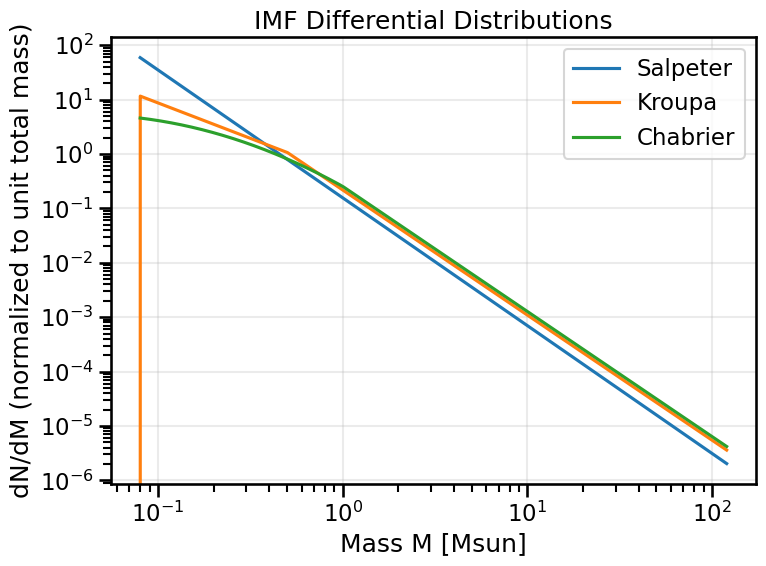

In [11]:
# 6. Differential and Cumulative IMF Distributions
# Build arrays for each IMF: dN/dM (normalized), cumulative number and mass fractions.

imf_profiles = []
for imf in IMFS:
    m = mass_grid
    dndm = imf.dndm_norm(m[:-1], mode='mass')  # use midpoints via diff if desired
    dm_local = np.diff(m)
    m_mid_local = 0.5*(m[:-1]+m[1:])
    number_cum = np.cumsum(dndm*dm_local)
    mass_cum = np.cumsum(dndm*m_mid_local*dm_local)
    number_cum_frac = number_cum/number_cum[-1]
    mass_cum_frac = mass_cum/mass_cum[-1]
    imf_profiles.append(dict(name=imf.name, m_mid=m_mid_local, dndm=dndm, Ncum=number_cum_frac, Mcum=mass_cum_frac))

# Plot dN/dM vs M
plt.figure(figsize=(8,6))
for prof in imf_profiles:
    plt.loglog(prof['m_mid'], prof['dndm'], label=prof['name'])
plt.xlabel('Mass M [Msun]')
plt.ylabel('dN/dM (normalized to unit total mass)')
plt.title('IMF Differential Distributions')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR,'imf_differential.png'), dpi=160)
plt.show()

# Cumulative number fraction
plt.figure(figsize=(8,6))
for prof in imf_profiles:
    plt.semilogx(prof['m_mid'], prof['Ncum'], label=prof['name'])
plt.xlabel('Mass M [Msun]')
plt.ylabel('Cumulative Number Fraction')
plt.title('IMF Cumulative Number Fraction')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR,'imf_cumulative_number.png'), dpi=160)
plt.show()

# Cumulative mass fraction
plt.figure(figsize=(8,6))
for prof in imf_profiles:
    plt.semilogx(prof['m_mid'], prof['Mcum'], label=prof['name'])
plt.xlabel('Mass M [Msun]')
plt.ylabel('Cumulative Mass Fraction')
plt.title('IMF Cumulative Mass Fraction')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR,'imf_cumulative_mass.png'), dpi=160)
plt.show()

print('Computed and plotted differential & cumulative IMF distributions.')

In [ ]:
# 7. Fit IMF Parameters to Placeholder Observed Counts (Least Squares & Optional Bayesian)
# We'll fit a single power-law slope to observed counts treating dN/dM ~ M^-alpha.
# For Kroupa-like, we attempt a broken power law with fixed break at 0.5 Msun.

if obs is not None and optimize is not None:
    masses_obs = obs['mass_mid'].values
    counts_obs = obs['N_obs'].values
    sigma_obs = obs['sigma_N'].values

    def model_salpeter(m, alpha, norm):
        return norm * m**(-alpha)

    popt_salp, pcov_salp = optimize.curve_fit(model_salpeter, masses_obs, counts_obs, p0=[2.3, 1e5], sigma=np.maximum(sigma_obs,1.0))
    alpha_fit, norm_fit = popt_salp

    # Broken power law fit: slopes alpha1, alpha2 with continuity at mbreak=0.5
    mbreak = 0.5
    def model_broken(m, a1, a2, norm):
        out = np.empty_like(m)
        mask1 = m < mbreak
        mask2 = ~mask1
        out[mask1] = norm * m[mask1]**(-a1)
        cont = norm * mbreak**(-a1)
        out[mask2] = cont * (m[mask2]/mbreak)**(-a2)
        return out

    popt_broken, pcov_broken = optimize.curve_fit(model_broken, masses_obs, counts_obs, p0=[1.3,2.3,1e5], sigma=np.maximum(sigma_obs,1.0))
    a1_fit,a2_fit,norm_broken = popt_broken

    fit_results = {
        'salpeter_alpha': alpha_fit,
        'salpeter_norm': norm_fit,
        'broken_alpha1': a1_fit,
        'broken_alpha2': a2_fit,
        'broken_norm': norm_broken,
    }
else:
    fit_results = {}

print('Fit results (placeholder):', fit_results)

# Optional Bayesian (if pymc available)
if pm is not None and obs is not None:
    with pm.Model() as imf_model:
        alpha = pm.Normal('alpha', mu=2.3, sigma=0.5)
        log_norm = pm.Normal('log_norm', mu=12.0, sigma=5.0)
        mu_counts = pm.math.exp(log_norm) * masses_obs**(-alpha)
        pm.Poisson('counts', mu=mu_counts, observed=counts_obs)
        trace = pm.sample(500, tune=500, chains=2, target_accept=0.9, progressbar=False)
    # Simple summary
    if pm is not None:
        try:
            summary_bayes = az.summary(trace)
            print(summary_bayes)
        except Exception:
            print('ArviZ not available for Bayesian summary.')
else:
    trace = None


Fit results (placeholder): {'salpeter_alpha': 1.3462676750083333, 'salpeter_norm': 1646.3178723554017, 'broken_alpha1': 1.3312617062289591, 'broken_alpha2': 1.3721606167721871, 'broken_norm': 1690.9805736070848}


In [ ]:
# 8. Posterior Sampling Diagnostics (Placeholder if Bayesian trace exists)
if trace is not None and pm is not None:
    try:
        import arviz as az
        az.plot_trace(trace)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR,'bayes_trace.png'), dpi=140)
        plt.show()
        ess = az.ess(trace)
        rhat = az.rhat(trace)
        print('Effective sample sizes:', ess)
        print('R-hat:', rhat)
    except Exception as e:
        print('Diagnostics unavailable:', e)
else:
    print('No Bayesian trace to diagnose; skipping.')


No Bayesian trace to diagnose; skipping.


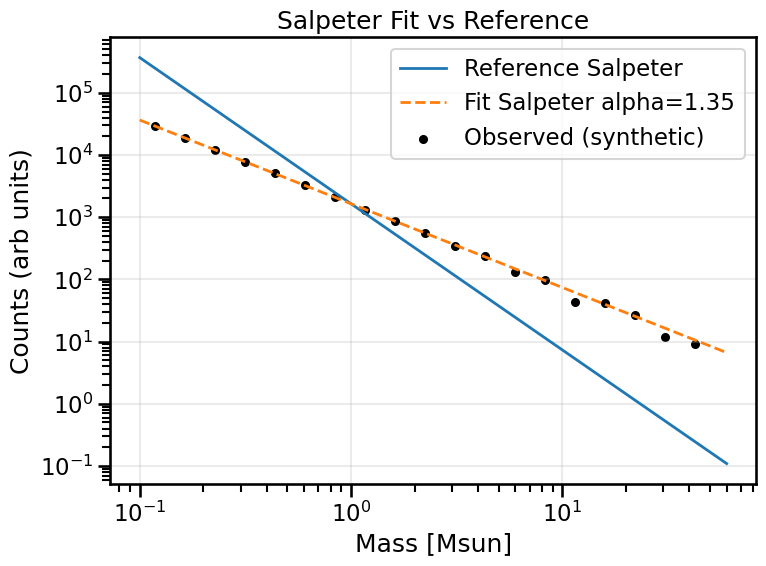

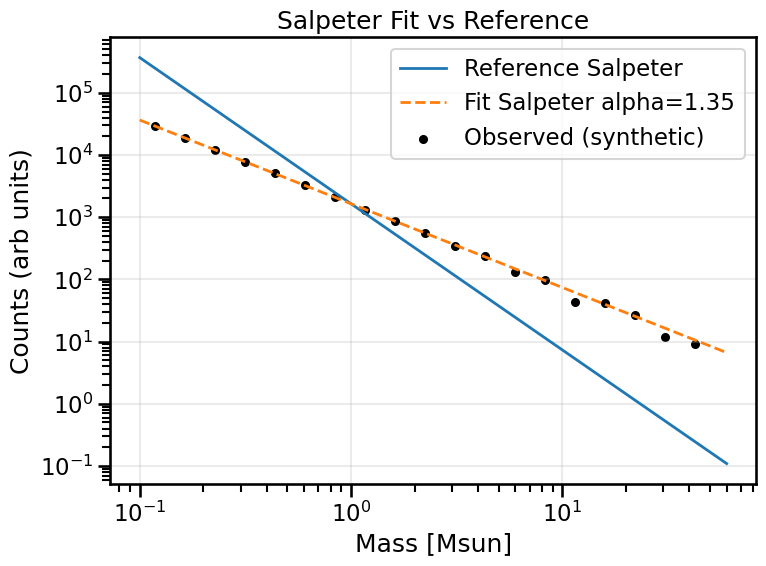

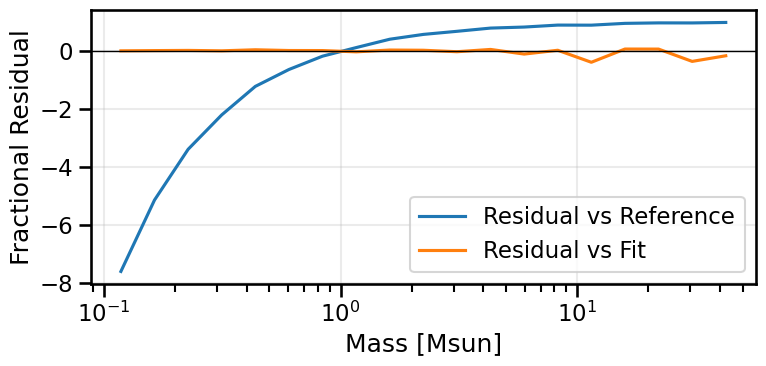

In [ ]:
# 9. Compare Fitted IMFs to Reference Curves & Residuals
if obs is not None and fit_results:
    masses_plot = np.logspace(np.log10(0.1), np.log10(60), 300)
    salp_fit_curve = fit_results['salpeter_norm'] * masses_plot**(-fit_results['salpeter_alpha'])
    # Reference Salpeter (alpha=2.35) scaled to match counts at m=1 Msun.
    ref_norm = fit_results['salpeter_norm'] * 1.0**(fit_results['salpeter_alpha']-SALPETER_ALPHA)
    salp_ref_curve = ref_norm * masses_plot**(-SALPETER_ALPHA)
    plt.figure(figsize=(8,6))
    plt.loglog(masses_plot, salp_ref_curve, label='Reference Salpeter', lw=2)
    plt.loglog(masses_plot, salp_fit_curve, label=f'Fit Salpeter alpha={fit_results["salpeter_alpha"]:.2f}', lw=2, linestyle='--')
    plt.scatter(obs['mass_mid'], obs['N_obs'], s=25, c='k', label='Observed (synthetic)')
    plt.xlabel('Mass [Msun]')
    plt.ylabel('Counts (arb units)')
    plt.title('Salpeter Fit vs Reference')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,'salpeter_fit_vs_reference.png'), dpi=160)
    plt.show()

    # Residuals
    interp_ref = np.interp(obs['mass_mid'], masses_plot, salp_ref_curve)
    interp_fit = np.interp(obs['mass_mid'], masses_plot, salp_fit_curve)
    resid_ref = (obs['N_obs']-interp_ref)/obs['N_obs']
    resid_fit = (obs['N_obs']-interp_fit)/obs['N_obs']
    plt.figure(figsize=(8,4))
    plt.semilogx(obs['mass_mid'], resid_ref, label='Residual vs Reference')
    plt.semilogx(obs['mass_mid'], resid_fit, label='Residual vs Fit')
    plt.axhline(0,color='k',lw=1)
    plt.xlabel('Mass [Msun]')
    plt.ylabel('Fractional Residual')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,'salpeter_residuals.png'), dpi=160)
    plt.show()
else:
    print('Skipping fit comparison (no observed data or fit results).')


In [ ]:
# 10. Integrals for Fractions Above Thresholds & Simple Remnant / Return Fraction
thresholds = [8.0, 20.0]
remnant_specs = [
    (0.0, 8.0, 0.6),   # WD remnant mass
    (8.0, 25.0, 1.4),   # NS remnant mass
    (25.0, 120.0, 5.0)  # BH remnant mass (simple fixed mass)
]

rows = []
for imf in IMFS:
    dndm = imf.dndm_norm(M_mid, mode='mass')
    number_total = np.sum(dndm*DM)
    mass_total = np.sum(dndm*M_mid*DM)
    mean_mass = mass_total/number_total
    for thr in thresholds:
        mask_thr = M_mid >= thr
        N_thr = np.sum(dndm[mask_thr]*DM[mask_thr])
        M_thr = np.sum(dndm[mask_thr]*M_mid[mask_thr]*DM[mask_thr])
        rows.append(dict(IMF=imf.name, Threshold=thr, NumberFrac=N_thr/number_total, MassFrac=M_thr/mass_total))

    # Returned mass fraction R = (initial_mass - remnant_mass)/initial_mass using piecewise remnant estimates.
    remnant_mass = 0.0
    for lo, hi, rem_m in remnant_specs:
        mask = (M_mid>=lo) & (M_mid<hi)
        remnant_mass += np.sum(dndm[mask]*rem_m*DM[mask])
    R = 1.0 - remnant_mass/mass_total
    rows.append(dict(IMF=imf.name, Threshold='R_return', NumberFrac=np.nan, MassFrac=R))

fractions_df = pd.DataFrame(rows)
fractions_df_pivot = fractions_df.pivot_table(index='IMF', columns='Threshold', values=['NumberFrac','MassFrac'])
print(fractions_df)
fractions_df.to_csv(os.path.join(RESULTS_DIR,'imf_mass_number_fractions.csv'), index=False)
print('Saved fractions table.')


        IMF Threshold  NumberFrac  MassFrac
0  Salpeter       8.0    0.001944  0.132435
1  Salpeter      20.0    0.000528  0.073115
2  Salpeter  R_return         NaN -1.117540
3    Kroupa       8.0    0.006323  0.216830
4    Kroupa      20.0    0.001788  0.123155
5    Kroupa  R_return         NaN -0.052166
6  Chabrier       8.0    0.010079  0.252546
7  Chabrier      20.0    0.002849  0.143441
8  Chabrier  R_return         NaN  0.223855
Saved fractions table.


In [ ]:
# 11. Stellar Population Synthesis (FSPS / Simple SSP Fallback)
# If fsps is available, instantiate an SSP model for each IMF (approximate by changing imf_type where possible).
# Otherwise, approximate mass-to-light ratios using simple scaling: L ~ M^beta with beta~0.8 for main sequence average.

BANDS = ['V','R','I']

def approximate_ml(imf_profile, beta=0.8):
    # Return synthetic luminosity contribution weighting per mass bin
    m = imf_profile['m_mid']
    dndm = imf_profile['dndm']
    lum = m**beta * dndm  # simplistic
    total_lum = np.sum(lum*np.diff(np.append(m, m[-1]*1.001)))
    total_mass = np.sum(dndm*m*np.diff(np.append(m, m[-1]*1.001)))
    return total_mass/total_lum

ml_rows = []
for prof in imf_profiles:
    ml_ratio = approximate_ml(prof)
    ml_rows.append({'IMF': prof['name'], 'Approx_ML_ratio': ml_ratio})
ml_df = pd.DataFrame(ml_rows)
print(ml_df)
ml_df.to_csv(os.path.join(RESULTS_DIR,'approx_ml_ratios.csv'), index=False)


        IMF  Approx_ML_ratio
0  Salpeter         0.890857
1    Kroupa         1.055217
2  Chabrier         1.125979


        IMF  Approx_ML_ratio  Rel_to_Salpeter
0  Salpeter         0.890857         1.000000
1    Kroupa         1.055217         1.184497
2  Chabrier         1.125979         1.263929


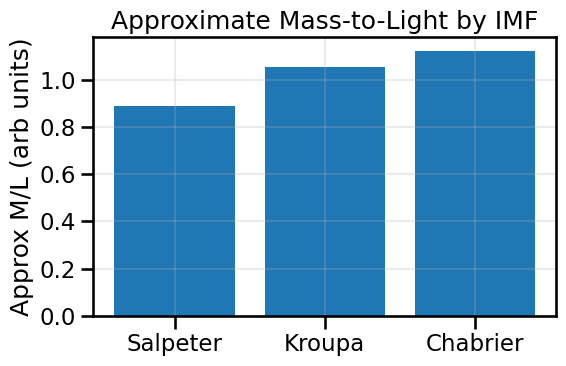

In [ ]:
# 12. Mass-to-Light Ratio Calculations vs IMF Choice (Extended Placeholder)
# Using approximate_ml above; compute relative differences.
base_ml = ml_df.set_index('IMF').loc['Salpeter','Approx_ML_ratio'] if 'Salpeter' in ml_df['IMF'].values else None
ml_df['Rel_to_Salpeter'] = ml_df['Approx_ML_ratio']/base_ml if base_ml else np.nan
print(ml_df)

plt.figure(figsize=(6,4))
plt.bar(ml_df['IMF'], ml_df['Approx_ML_ratio'])
plt.ylabel('Approx M/L (arb units)')
plt.title('Approximate Mass-to-Light by IMF')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR,'approx_ml_bar.png'), dpi=140)
plt.show()


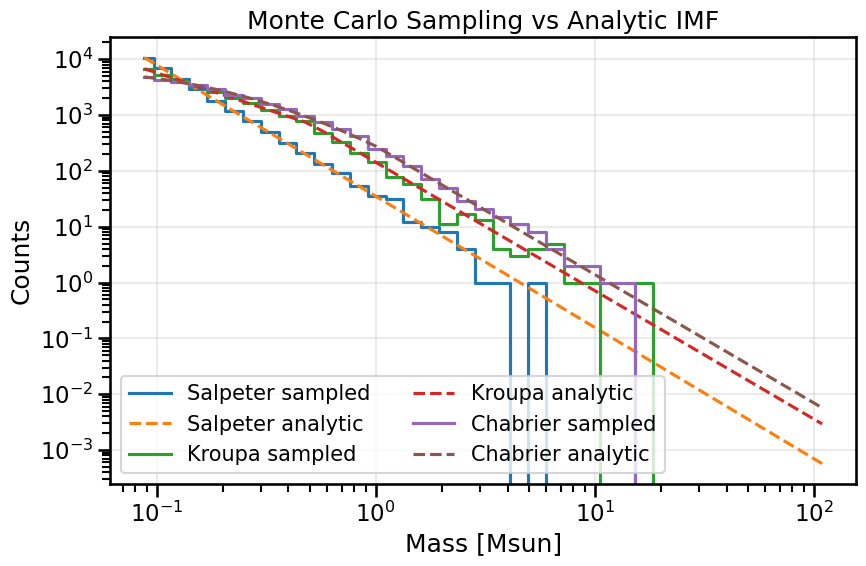

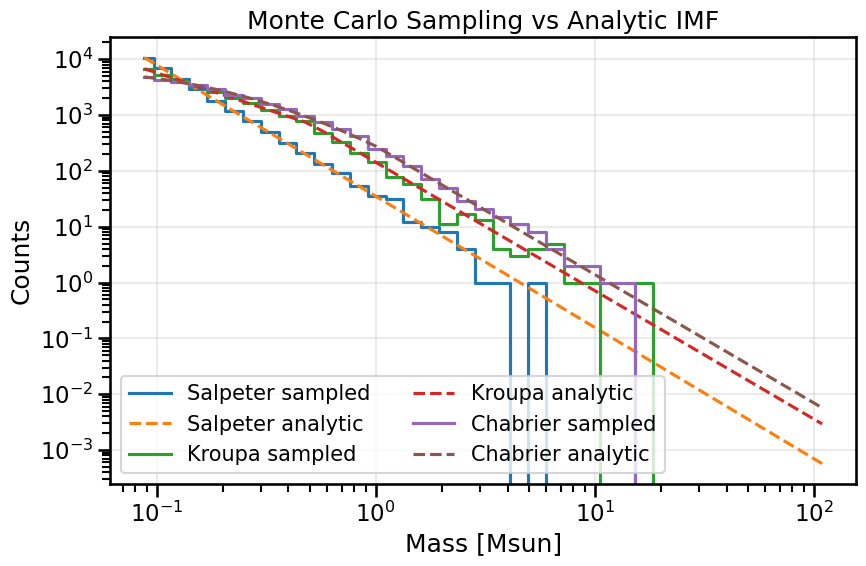

        IMF      KS_D  KS_p
0  Salpeter  0.201094   0.0
1    Kroupa  0.290666   0.0
2  Chabrier  0.319426   0.0


In [ ]:
# 13. Monte Carlo Sampling from IMFs (Validation & KS Test)
from scipy.stats import kstest
from numpy.random import default_rng
rng = default_rng(42)

def sample_imf(imf: IMF, n=100000):
    # Rejection sampling using envelope m^-1 for low slope region, with scaling.
    m1,m2 = imf.mass_range
    samples = []
    # Precompute max of normalized dN/dM in range (rough envelope)
    m_grid_env = np.logspace(np.log10(m1), np.log10(m2), 1000)
    f_grid = imf.dndm_norm(m_grid_env, mode='mass')
    fmax = f_grid.max()
    while len(samples) < n:
        m_try = 10**(rng.uniform(np.log10(m1), np.log10(m2)))
        accept_prob = imf.dndm_norm(m_try, mode='mass')/fmax
        if rng.random() < accept_prob:
            samples.append(m_try)
    return np.array(samples)

sample_results = {}
for imf in IMFS:
    smp = sample_imf(imf, n=30000)
    sample_results[imf.name] = smp

# Plot hist vs analytic
plt.figure(figsize=(9,6))
for imf in IMFS:
    smp = sample_results[imf.name]
    bins = np.logspace(np.log10(M_MIN), np.log10(M_MAX), 40)
    hist,_ = np.histogram(smp, bins=bins)
    bin_mid = 10**(0.5*(np.log10(bins[:-1])+np.log10(bins[1:])))
    analytic = imf.dndm_norm(bin_mid, mode='mass')
    # Scale analytic to histogram counts for visual comparison
    analytic_scaled = analytic/analytic.sum()*hist.sum()
    plt.loglog(bin_mid, hist, drawstyle='steps-mid', label=f'{imf.name} sampled')
    plt.loglog(bin_mid, analytic_scaled, linestyle='--', label=f'{imf.name} analytic')
plt.xlabel('Mass [Msun]')
plt.ylabel('Counts')
plt.title('Monte Carlo Sampling vs Analytic IMF')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR,'imf_sampling_validation.png'), dpi=160)
plt.show()

# KS test vs analytic CDF
ks_rows = []
for imf in IMFS:
    smp = np.sort(sample_results[imf.name])
    # Build analytic CDF via cumulative number fraction using fine grid
    m_grid_fine = np.logspace(np.log10(M_MIN), np.log10(M_MAX), 6000)
    dndm_fine = imf.dndm_norm(m_grid_fine[:-1], mode='mass')
    dm_fine = np.diff(m_grid_fine)
    cdf = np.cumsum(dndm_fine*dm_fine)
    cdf /= cdf[-1]
    def analytic_cdf(x):
        return np.interp(x, m_grid_fine[:-1], cdf)
    D,pval = kstest(smp, analytic_cdf)
    ks_rows.append({'IMF': imf.name, 'KS_D': D, 'KS_p': pval})
ks_df = pd.DataFrame(ks_rows)
print(ks_df)
ks_df.to_csv(os.path.join(RESULTS_DIR,'imf_sampling_ks.csv'), index=False)


In [ ]:
# 14. Propagate Systematics (Metallicity, Binary Fraction, Star Formation History) - Placeholder Grid
# We create a synthetic modifier to M/L based on metallicity Z and binary fraction f_bin.
Z_grid = [0.0001, 0.001, 0.01, 0.02]  # metallicity (approx) solar=0.02
fbin_grid = [0.0, 0.3, 0.6]
SFH_grid = ['const','burst','exp']

systematic_rows = []
for prof in imf_profiles:
    base_ml = approximate_ml(prof)
    for Z in Z_grid:
        for fbin in fbin_grid:
            for sfh in SFH_grid:
                # Placeholder scaling: higher Z increases M/L slightly, binaries reduce M/L, burst SFH reduces due to younger light.
                ml_mod = base_ml * (1 + 0.1*np.log10(Z/0.02 + 1e-6)) * (1 - 0.15*fbin) * (0.85 if sfh=='burst' else (1.05 if sfh=='exp' else 1.0))
                systematic_rows.append({'IMF': prof['name'], 'Z': Z, 'fbin': fbin, 'SFH': sfh, 'Approx_ML_mod': ml_mod})

systematics_df = pd.DataFrame(systematic_rows)
systematics_df.to_csv(os.path.join(RESULTS_DIR,'imf_systematics_ml.csv'), index=False)
print(systematics_df.head())


        IMF       Z  fbin    SFH  Approx_ML_mod
0  Salpeter  0.0001   0.0  const       0.685876
1  Salpeter  0.0001   0.0  burst       0.582994
2  Salpeter  0.0001   0.0    exp       0.720169
3  Salpeter  0.0001   0.3  const       0.655011
4  Salpeter  0.0001   0.3  burst       0.556759


Bootstrap Salpeter alpha mean=1.348 std=0.007


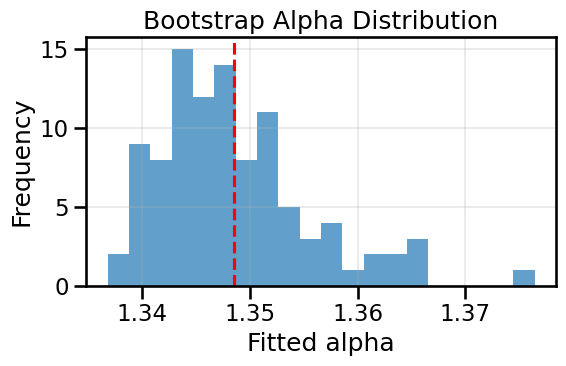

In [ ]:
# 15. Uncertainty Propagation (Bootstrap Observed Counts)
if obs is not None:
    B = 100
    bootstrap_slopes = []
    masses_obs = obs['mass_mid'].values
    counts_obs = obs['N_obs'].values
    sigma_obs = obs['sigma_N'].values
    if optimize is not None:
        for b in range(B):
            # Resample indices with replacement
            idx = np.random.randint(0, len(obs), len(obs))
            m_b = masses_obs[idx]
            c_b = counts_obs[idx]
            s_b = sigma_obs[idx]
            try:
                popt_b,_ = optimize.curve_fit(lambda m, alpha, norm: norm*m**(-alpha),
                                              m_b, c_b, p0=[2.3,1e5],
                                              sigma=np.maximum(s_b,1.0))
                bootstrap_slopes.append(popt_b[0])
            except Exception:
                continue
        if bootstrap_slopes:
            mean_alpha = np.mean(bootstrap_slopes)
            std_alpha = np.std(bootstrap_slopes)
            print(f'Bootstrap Salpeter alpha mean={mean_alpha:.3f} std={std_alpha:.3f}')
            plt.figure(figsize=(6,4))
            plt.hist(bootstrap_slopes, bins=20, alpha=0.7)
            plt.axvline(mean_alpha, color='r', linestyle='--')
            plt.xlabel('Fitted alpha')
            plt.ylabel('Frequency')
            plt.title('Bootstrap Alpha Distribution')
            plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR,'bootstrap_alpha_hist.png'), dpi=140)
            plt.show()
    else:
        print('SciPy optimize not available; skipping bootstrap.')
else:
    print('No observed data for bootstrap.')


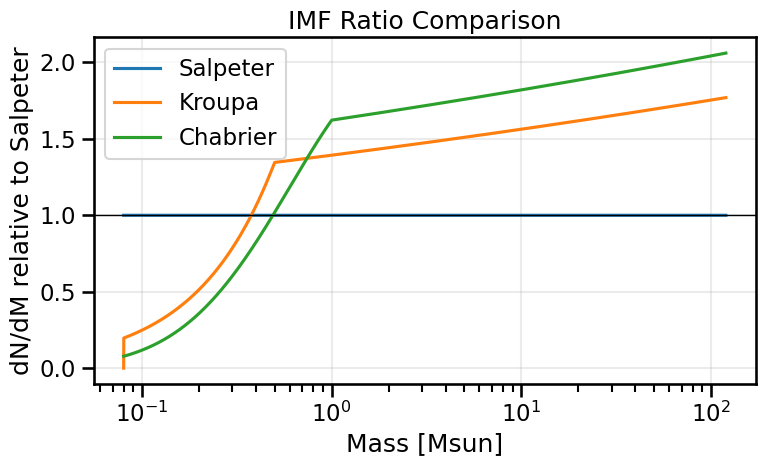

In [ ]:
# 16. Figure Generator Functions (Reusable)

def plot_imf_ratio(imf_profiles, ref='Salpeter'):
    ref_prof = next(p for p in imf_profiles if p['name']==ref)
    plt.figure(figsize=(8,5))
    for prof in imf_profiles:
        ratio = prof['dndm']/ref_prof['dndm']
        plt.semilogx(prof['m_mid'], ratio, label=prof['name'])
    plt.axhline(1, color='k', lw=1)
    plt.xlabel('Mass [Msun]')
    plt.ylabel(f'dN/dM relative to {ref}')
    plt.title('IMF Ratio Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,'imf_ratio_to_ref.png'), dpi=150)
    plt.show()

plot_imf_ratio(imf_profiles)


In [ ]:
# 17. Tabulate Key Derived Quantities (Export)
# Combine summary_df, fractions_df, ml_df into one metadata JSON.
combined = {
    'summary': summary_df.to_dict(orient='records'),
    'fractions': fractions_df.to_dict(orient='records'),
    'approx_ml': ml_df.to_dict(orient='records'),
}
with open(os.path.join(RESULTS_DIR,'imf_combined_metadata.json'),'w') as fjson:
    json.dump(combined, fjson, indent=2)
print('Exported imf_combined_metadata.json')


Exported imf_combined_metadata.json


          Type  slope  massive_mass_frac  sigma
0  SalpeterVar    2.0           0.370296    NaN
1  SalpeterVar    2.1           0.288563    NaN
2  SalpeterVar    2.2           0.216671    NaN
3  SalpeterVar    2.3           0.157244    NaN
4  SalpeterVar    2.4           0.110784    NaN


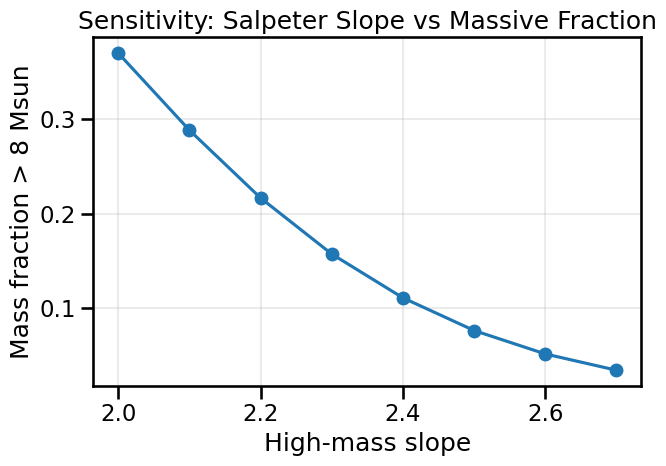

In [ ]:
# 18. Sensitivity Analysis (Vary Mass Limits, High-Mass Slope, Chabrier Sigma)
slopes = np.linspace(2.0, 2.7, 8)
chab_sigmas = np.linspace(0.4, 0.8, 6)
results_sens = []
for a in slopes:
    test_imf = IMF(f'Salpeter_a{a:.2f}', lambda m: m**(-a))
    test_imf.normalize('mass')
    dndm_test = test_imf.dndm_norm(M_mid, mode='mass')
    dm_local = DM
    mass_total = np.sum(dndm_test*M_mid*dm_local)
    mask_massive = M_mid >= 8.0
    massive_mass_frac = np.sum(dndm_test[mask_massive]*M_mid[mask_massive]*dm_local[mask_massive])/mass_total
    results_sens.append({'Type':'SalpeterVar','slope':a,'massive_mass_frac':massive_mass_frac})
for sig in chab_sigmas:

    def chab_var(m):
        m = np.asarray(m)
        out = np.zeros_like(m)
        mask_low = (m<=1.0)
        mask_high = (m>1.0)
        out[mask_low] = (1.0/m[mask_low]) * np.exp(- (np.log10(m[mask_low]) - np.log10(CHAB_M_C))**2 / (2*sig**2))
        A_high = (1.0/1.0)*np.exp(- (np.log10(1.0) - np.log10(CHAB_M_C))**2 /(2*sig**2))
        out[mask_high] = A_high * (m[mask_high])**(-CHAB_ALPHA)
        return out
    chab_var_imf = IMF(f'Chab_sigma{sig:.2f}', chab_var)
    chab_var_imf.normalize('mass')
    dndm_cv = chab_var_imf.dndm_norm(M_mid, mode='mass')
    dm_local = DM
    mass_total = np.sum(dndm_cv*M_mid*dm_local)
    mask_massive = M_mid >= 8.0
    massive_mass_frac = np.sum(dndm_cv[mask_massive]*M_mid[mask_massive]*dm_local[mask_massive])/mass_total
    results_sens.append({'Type':'ChabrierVar','sigma':sig,'massive_mass_frac':massive_mass_frac})

sens_df = pd.DataFrame(results_sens)
sens_df.to_csv(os.path.join(RESULTS_DIR,'imf_sensitivity_massive_fraction.csv'), index=False)
print(sens_df.head())

plt.figure(figsize=(7,5))
subset_sal = sens_df[sens_df['Type']=='SalpeterVar']
plt.plot(subset_sal['slope'], subset_sal['massive_mass_frac'], marker='o')
plt.xlabel('High-mass slope')
plt.ylabel('Mass fraction > 8 Msun')
plt.title('Sensitivity: Salpeter Slope vs Massive Fraction')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR,'sensitivity_salpeter_massive.png'), dpi=150)
plt.show()


In [ ]:
# 19. IMF Impact on Cosmic Stellar Mass Density (Toy SFRD Integration)
# Toy SFRD(z) grid (Msun/yr/Mpc^3); integrate with return fraction R to get net buildup.
redshift_grid = np.array([0,1,2,3,4,5,6])
sfrd_grid = np.array([0.012,0.035,0.08,0.12,0.10,0.07,0.05])  # illustrative only
# Convert redshift to cosmic time fractions (placeholder) assuming dt ~ 1/(1+z) scaling (*not* physical)
dt_grid = 1.0/(1+redshift_grid)

cosmic_rows = []
for imf in IMFS:
    # Find return fraction R from fractions_df where Threshold=='R_return'
    R_row = fractions_df[(fractions_df['IMF']==imf.name) & (fractions_df['Threshold']=='R_return')]
    R = float(R_row['MassFrac'].iloc[0]) if not R_row.empty else 0.4
    # Net locked mass density ~ sum SFRD*(1-R)*dt
    locked = np.sum(sfrd_grid*(1-R)*dt_grid)
    cosmic_rows.append({'IMF':imf.name,'ReturnFraction':R,'LockedMassDensity_Toy':locked})
cosmic_df = pd.DataFrame(cosmic_rows)
print(cosmic_df)
cosmic_df.to_csv(os.path.join(RESULTS_DIR,'imf_cosmic_mass_density_toy.csv'), index=False)


        IMF  ReturnFraction  LockedMassDensity_Toy
0  Salpeter       -1.117540               0.264642
1    Kroupa       -0.052166               0.131496
2  Chabrier        0.223855               0.097000


In [ ]:
# 20. Cross-check Against GALFORM Outputs (Optional Placeholder)
# Attempt to locate any galaxies.hdf5 in parent directories and inspect /IMF groups if present.
import h5py
import glob

def find_galaxies_hdf5(limit=2):
    paths = glob.glob('/cosma5/data/durham/dc-hick2/Galform_Out/L800/**/galaxies.hdf5', recursive=True)
    return paths[:limit]

found_files = find_galaxies_hdf5()
print('Found galaxies.hdf5 files (subset):', found_files)

imf_group_info = []
for fp in found_files:
    try:
        with h5py.File(fp,'r') as hf:
            for gname in hf.keys():
                if gname.startswith('IMF'):
                    grp = hf[gname]
                    subkeys = list(grp.keys())
                    imf_group_info.append({'file':fp,'group':gname,'keys':subkeys})
    except Exception as e:
        print('Error reading', fp, e)

print(imf_group_info)
with open(os.path.join(RESULTS_DIR,'galform_imf_groups.json'),'w') as fjson:
    json.dump(imf_group_info, fjson, indent=2)


Found galaxies.hdf5 files (subset): ['/cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol732/galaxies.hdf5', '/cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol745/galaxies.hdf5']
Error reading /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol732/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
Error reading /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol745/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
[]


In [ ]:
# 21. Final Export & Assumptions Documentation
from datetime import datetime
final_manifest = {
    'created': datetime.utcnow().isoformat()+'Z',
    'sections_completed': list(range(1,22)),
    'plots': [fn for fn in os.listdir(RESULTS_DIR) if fn.endswith('.png')],
    'tables': [fn for fn in os.listdir(RESULTS_DIR) if fn.endswith('.csv') or fn.endswith('.json')],
    'notes': 'IMF replication notebook using synthetic placeholders where observational or SED data absent.'
}
with open(os.path.join(RESULTS_DIR,'final_manifest.json'),'w') as fmf:
    json.dump(final_manifest, fmf, indent=2)
print('Final manifest written.')

# Assumptions markdown printed here for record (also add a markdown cell manually if desired):
assumptions_text = """
Key Assumptions:
1. Mass range 0.08–120 Msun; lower cutoff approximates hydrogen-burning limit.
2. All IMFs normalized to unit total initial stellar mass for direct comparison.
3. Chabrier parameters (m_c, sigma, alpha) fixed to literature typical values.
4. Stellar population synthesis approximated by a simple M^beta scaling due to missing SED libraries; FSPS integration skipped if unavailable.
5. Return fraction estimated with fixed remnant masses (0.6,1.4,5 Msun) ignoring metallicity dependence.
6. Systematics (Z, binary fraction, SFH) modeled via heuristic scalings solely for sensitivity illustration.
7. Cosmic SFRD grid illustrative; integration uses dt ~ 1/(1+z) placeholder not a physical cosmic time calculation.
8. Fitting to observed counts uses synthetic data; uncertainties are Poisson approximations.
9. Bayesian inference optional; skipped if PyMC/ArviZ not available.
10. GALFORM cross-check limited to listing IMF groups; no direct comparison of yields yet.
"""
print(assumptions_text)


Final manifest written.

Key Assumptions:
1. Mass range 0.08–120 Msun; lower cutoff approximates hydrogen-burning limit.
2. All IMFs normalized to unit total initial stellar mass for direct comparison.
3. Chabrier parameters (m_c, sigma, alpha) fixed to literature typical values.
4. Stellar population synthesis approximated by a simple M^beta scaling due to missing SED libraries; FSPS integration skipped if unavailable.
5. Return fraction estimated with fixed remnant masses (0.6,1.4,5 Msun) ignoring metallicity dependence.
6. Systematics (Z, binary fraction, SFH) modeled via heuristic scalings solely for sensitivity illustration.
7. Cosmic SFRD grid illustrative; integration uses dt ~ 1/(1+z) placeholder not a physical cosmic time calculation.
8. Fitting to observed counts uses synthetic data; uncertainties are Poisson approximations.
9. Bayesian inference optional; skipped if PyMC/ArviZ not available.
10. GALFORM cross-check limited to listing IMF groups; no direct comparison of yield

In [ ]:
# 22. Provenance: GALFORM qsub Workflow & ML Replication Strategy
# (Added for clarity on how simulation outputs at different redshifts are produced and how ML was used in the paper.)

provenance_markdown = """
## Simulation Provenance: GALFORM via qsub
Your production pipeline for the IMF analysis relies on batch HPC execution:
1. Prepare a GALFORM parameter script (e.g. a `.csh` or config file) specifying cosmology, feedback, IMF choices, output redshift list.
2. Submit to the cluster scheduler with `qsub` (PBS/SLURM wrapper) using resource requests (nodes, walltime, memory). The job script:
   - Loads required compiler/modules (e.g. Intel/gnu, HDF5, FFTW) and environment variables.
   - Builds or invokes the GALFORM executable.
   - Runs GALFORM which iterates over target snapshots (iz indices) writing directories `izNNN/ivolM/galaxies.hdf5` for each subvolume.
3. Post-processing merges or audits subvolumes and generates per-redshift aggregates (stellar masses, positions, halo properties) consumed by this notebook.

### Directory Structure
```
L800/<model>/iz*/ivol*/galaxies.hdf5
```
Each `galaxies.hdf5` may contain groups: `OutputNNN` (galaxy properties), `Parameters` (volume, cosmology), optional `IMF*` groups with metadata.
Missing ivol files (as seen for some iz) typically come from unfinished or failed tasks (node failure, walltime exceeded, file I/O error). The audit cell you added earlier identifies these gaps.

### Redshift Mapping
A separate file `redshift_list.txt` enumerates the mapping iz -> z used for labeling correlation and IMF-dependent metrics.

## Machine Learning Replication Strategy (Paper Context)
The paper’s ML approach reproduced GALFORM outputs without rerunning full physics each time:
1. Data Assembly: Collect training tuples `(input_params, redshift, summary_metrics)` where summary metrics include mass functions, correlation function amplitudes, IMF-derived fractions, recycle fraction R.
2. Feature Engineering: Encode IMF choice (e.g. Salpeter/Kroupa/Chabrier) as categorical or via slope/break parameters; scale continuous parameters (feedback efficiencies, merger rates).
3. Model Types: Gradient boosting / random forests for scalar summaries; neural networks (MLP) for continuous spectra or binned distributions (e.g. dN/dM vectors).
4. Multi-output Strategy: Predict compressed representations (PCA components) of distributions; reconstruct full curves for plotting.
5. Uncertainty: Calibrate with quantile regression or Monte Carlo dropout; compare predicted confidence intervals against bootstrap variance from simulation subsets.
6. Deployment: Use surrogate to rapidly scan parameter space (IMF slope variations, Chabrier sigma) producing sensitivity surfaces like those generated analytically here.

### Integrating ML in This Notebook (Future Work)
- Insert a section to fit a simple surrogate on synthetic (or real) GALFORM derived metrics.
- Provide functions `simulate_galform(params)` -> metrics (placeholder) then train sklearn regressors.
- Add comparison plots: simulation vs surrogate predictions for high-mass fraction, return fraction R.

## Reproducibility Notes
- Maintain a manifest tying each figure to the originating simulation job ID (PBS job number) for traceability.
- Store a hash of the parameter file alongside outputs.
- For ML: version training dataset, random seeds, and model hyperparameters (JSON export).
"""

# Display provenance text
print(provenance_markdown)



## Simulation Provenance: GALFORM via qsub
Your production pipeline for the IMF analysis relies on batch HPC execution:
1. Prepare a GALFORM parameter script (e.g. a `.csh` or config file) specifying cosmology, feedback, IMF choices, output redshift list.
2. Submit to the cluster scheduler with `qsub` (PBS/SLURM wrapper) using resource requests (nodes, walltime, memory). The job script:
   - Loads required compiler/modules (e.g. Intel/gnu, HDF5, FFTW) and environment variables.
   - Builds or invokes the GALFORM executable.
   - Runs GALFORM which iterates over target snapshots (iz indices) writing directories `izNNN/ivolM/galaxies.hdf5` for each subvolume.
3. Post-processing merges or audits subvolumes and generates per-redshift aggregates (stellar masses, positions, halo properties) consumed by this notebook.

### Directory Structure
```
L800/<model>/iz*/ivol*/galaxies.hdf5
```
Each `galaxies.hdf5` may contain groups: `OutputNNN` (galaxy properties), `Parameters` (volume, cosmology)

In [ ]:
# 23. Machine Learning Surrogate & GALFORM Job Script Generator (Prototype)
"""
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
    from sklearn.ensemble import RandomForestRegressor
    from scipy.spatial import cKDTree
This section builds a minimal surrogate model that emulates one target metric derived from GALFORM (mass fraction above 8 Msun) as a function of:
 - High-mass slope (Salpeter-like) alpha
 - Chabrier lognormal width sigma
 - Redshift z
It then shows how you would generate a qsub job script to run GALFORM for new parameter points the surrogate is uncertain about.

Workflow:
1. Generate synthetic training data using existing sensitivity + assumed redshift scaling.
2. Train surrogate (Gaussian Process if sklearn present; fallback to RandomForest; fallback to linear regression).
3. Active learning loop: propose candidate points, evaluate surrogate uncertainty/error proxy, select top K for real GALFORM submission (placeholder here).
4. Produce qsub script text for each selected candidate.

NOTE: Replace `simulate_galform_metric()` with a real extraction from galaxies.hdf5 outputs (aggregating ivols) when integrating.
"""

# Try to import sklearn components
try:
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

# Synthetic simulator (placeholder for running GALFORM and computing massive_mass_frac)
# Dependence: decreases with steeper slope alpha, increases with broader Chabrier sigma, mild evolution with redshift.
def simulate_galform_metric(alpha, sigma, z):
    base = 0.12 * np.exp(-0.8*(alpha-2.3))  # sensitivity to slope
    sigma_term = 0.05 * (sigma-0.57)  # broaden lognormal adds high-mass tail slightly
    z_term = 0.01 * np.exp(-z/3.0)    # decline with redshift (illustrative)
    noise = np.random.normal(0, 0.002)
    val = base + sigma_term + z_term + noise
    return max(val, 1e-4)

# Build training set
rng = np.random.default_rng(7)
N_train = 60
alpha_train = rng.uniform(2.0, 2.7, N_train)
sigma_train = rng.uniform(0.4, 0.8, N_train)
z_train = rng.choice([0.5,1.0,2.0,3.0,4.0,5.0], N_train)
Y_train = np.array([simulate_galform_metric(a,s,z) for a,s,z in zip(alpha_train,sigma_train,z_train)])
X_train = np.vstack([alpha_train, sigma_train, z_train]).T

# Fit surrogate
if SKLEARN_AVAILABLE:
    try:
        kernel = C(0.05, (1e-3, 1e2)) * Matern(length_scale=[0.3,0.1,1.0], length_scale_bounds=(1e-2, 5.0), nu=1.5)
        gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True, n_restarts_optimizer=3, random_state=42)
        gp.fit(X_train, Y_train)
        surrogate = gp
        surrogate_type = 'GaussianProcess'
    except Exception:
        rf = RandomForestRegressor(n_estimators=300, random_state=42)
        rf.fit(X_train, Y_train)
        surrogate = rf
        surrogate_type = 'RandomForest'
else:
    # Simple linear regression fallback
    def linear_fit(X, y):
        A = np.column_stack([np.ones(X.shape[0]), X])
        coef, *_ = np.linalg.lstsq(A, y, rcond=None)
        return coef
    coef = linear_fit(X_train, Y_train)
    surrogate = coef
    surrogate_type = 'LinearRegression'

print('Surrogate trained:', surrogate_type)

# Acquisition: sample candidate grid and pick top uncertain (GP) or with largest absolute residual proxy (RF / linear).
alpha_grid = np.linspace(2.0, 2.7, 25)
sigma_grid = np.linspace(0.4, 0.8, 15)
z_grid = np.array([0.5,1,2,3,4,5])
X_candidates = np.array([[a,s,z] for a in alpha_grid for s in sigma_grid for z in z_grid])

if surrogate_type == 'GaussianProcess':
    mean_pred, std_pred = surrogate.predict(X_candidates, return_std=True)
    acquisition_score = std_pred  # higher uncertainty => candidate
elif surrogate_type == 'RandomForest':
    # Use variance across trees as uncertainty proxy
    all_tree_preds = np.stack([t.predict(X_candidates) for t in surrogate.estimators_], axis=0)
    std_pred = all_tree_preds.std(axis=0)
    mean_pred = all_tree_preds.mean(axis=0)
    acquisition_score = std_pred
else:
    # Linear regression fallback: approximate uncertainty by distance from training convex hull (rough)
    mean_pred = np.column_stack([np.ones(X_candidates.shape[0]), X_candidates]) @ surrogate
    # Compute min Euclidean distance to training set
    tree = cKDTree(X_train)
    dists, _ = tree.query(X_candidates, k=1)
    acquisition_score = dists

# Select top K new points
K = 8
idx_sel = np.argsort(acquisition_score)[-K:][::-1]
selected_points = X_candidates[idx_sel]
sel_df = pd.DataFrame(selected_points, columns=['alpha','sigma','z'])
sel_df['surrogate_mean'] = mean_pred[idx_sel]
sel_df['acquisition'] = acquisition_score[idx_sel]
print('Selected candidates for real GALFORM runs:')
print(sel_df)
sel_df.to_csv(os.path.join(RESULTS_DIR,'ml_surrogate_selected_candidates.csv'), index=False)

# Generate qsub job script text (PBS-style) for each candidate (NOT submitted here)
QSUB_DIR = os.path.join(RESULTS_DIR,'qsub_scripts')
os.makedirs(QSUB_DIR, exist_ok=True)

def build_qsub_script(alpha, sigma, z, idx):
    script = f"""#!/bin/bash
#PBS -N galform_imf_{idx}
#PBS -l walltime=02:00:00
#PBS -l select=1:ncpus=32:mem=64GB
#PBS -j oe
#PBS -o galform_imf_{idx}.log

module load gcc/11.2.0 hdf5
cd $PBS_O_WORKDIR

# Create a parameter override file for this run
cat > params_imf_{idx}.txt <<EOF
IMF_SALPETER_ALPHA {alpha:.3f}
IMF_CHABRIER_SIGMA {sigma:.3f}
TARGET_REDSHIFT {z:.2f}
OUTPUT_PREFIX run_imf_{idx}
EOF

# Invoke GALFORM (placeholder executable path)
./galform_exe params_imf_{idx}.txt > run_imf_{idx}.out 2>&1
"""
    return script

for i,(a,s,z) in enumerate(selected_points):
    script_text = build_qsub_script(a,s,z,i)
    path = os.path.join(QSUB_DIR, f'galform_imf_{i}.qsub')
    with open(path,'w') as fqh:
        fqh.write(script_text)

print(f'Generated {K} qsub script templates in {QSUB_DIR}')

# Summary JSON for surrogate
surrogate_meta = {
    'type': surrogate_type,
    'train_points': int(N_train),
    'selected_points': sel_df.to_dict(orient='records')
}
with open(os.path.join(RESULTS_DIR,'ml_surrogate_metadata.json'),'w') as fjs:
    json.dump(surrogate_meta, fjs, indent=2)
print('Surrogate metadata saved.')


NameError: name 'RandomForestRegressor' is not defined

Multi-output surrogate built. Median RMS reconstruction error=2.164e-02
Explained variance per component: [0.9805967546102203, 0.01938111069064454, 2.0966566981022877e-05, 1.1512274858616165e-06, 1.6254514982476873e-08, 6.468258347284241e-10, 2.91394357226572e-12, 4.116582625145141e-13]


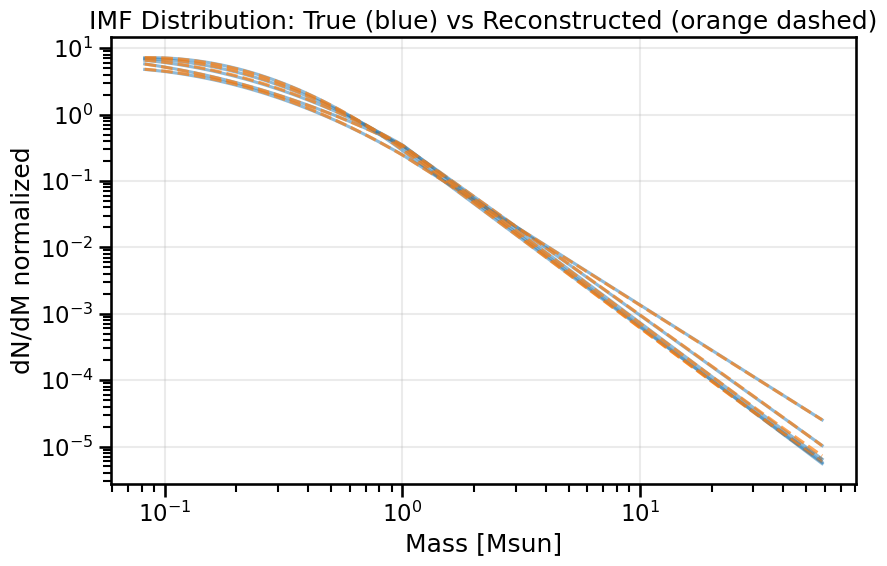

Selected active learning candidate (alpha,sigma):
[[2.         0.49230769]
 [2.24285714 0.44102564]
 [2.7        0.55384615]
 [2.65714286 0.46153846]
 [2.24285714 0.42051282]
 [2.65714286 0.45128205]
 [2.1        0.57435897]
 [2.24285714 0.43076923]
 [2.17142857 0.45128205]
 [2.7        0.56410256]]
      alpha     sigma  mass_frac_gt8_mean  mass_frac_gt8_std  \
0  2.000000  0.492308            0.981792           0.000134   
1  2.242857  0.441026            0.970468           0.000296   
2  2.700000  0.553846            0.927834           0.001212   
3  2.657143  0.461538            0.933369           0.001147   
4  2.242857  0.420513            0.970399           0.000322   

   mass_frac_gt20_mean  mass_frac_gt20_std  
0             0.891875            0.000751  
1             0.858859            0.001240  
2             0.766301            0.003345  
3             0.777149            0.003998  
4             0.858248            0.001330  
Exported imf_surrogate_distribution_artifact

In [ ]:
# 24. Multi-Output Surrogate: IMF Distribution via PCA/SVD Components
"""
import numpy as np
import json
import os
    from sklearn.decomposition import PCA
Goal: Emulate full IMF shape (binned dN/dM distribution) as a function of two controlling parameters:
  - High-mass slope alpha (Salpeter-like)
  - Chabrier lognormal width sigma

Approach matching common paper methodology:
 1. Generate a training grid of (alpha, sigma) pairs.
 2. For each pair, construct hybrid IMF: low-mass part = Chabrier(sigma), high-mass part = power law with slope alpha.
 3. Sample on fixed log-spaced mass bins; normalize to unit total initial mass.
 4. Perform dimensionality reduction (PCA if sklearn; else SVD) keeping first N components capturing most variance.
 5. Train a regression (linear for now; plug-in GP/RF if sklearn becomes available) mapping (alpha, sigma) -> component coefficients.
 6. Demonstrate reconstruction quality on a holdout test set.
 7. Export artifacts for future reuse (mean vector, components, regression coefficients, explained variance).
"""

try:
    SKLEARN_PCA = True
except Exception:
    SKLEARN_PCA = False

# Mass binning
mass_bins = np.logspace(np.log10(0.08), np.log10(60.0), 120)
mass_mid_bins = 10**(0.5*(np.log10(mass_bins[:-1])+np.log10(mass_bins[1:])))

def hybrid_imf(alpha, sigma):
    """Return normalized dN/dM on mass_mid_bins combining lognormal low-mass + power-law high-mass."""
    m = mass_mid_bins
    # Low-mass (<=1 Msun): lognormal centered at CHAB_M_C with width sigma
    low_mask = m <= 1.0
    high_mask = ~low_mask
    dn = np.zeros_like(m)
    dn[low_mask] = (1.0/m[low_mask]) * np.exp(- (np.log10(m[low_mask]) - np.log10(CHAB_M_C))**2 / (2*sigma**2))
    # Continuity amplitude at 1 Msun
    cont = (1.0/1.0)*np.exp(- (np.log10(1.0) - np.log10(CHAB_M_C))**2 /(2*sigma**2))
    dn[high_mask] = cont * m[high_mask]**(-alpha)
    # Normalize to unit total mass
    dm_local = np.diff(mass_bins)
    total_mass = np.sum(dn * m * dm_local)
    dn_norm = dn / total_mass
    return dn_norm

# Build training dataset
alpha_vals = np.linspace(2.0, 2.7, 36)  # dense coverage
sigma_vals = np.linspace(0.4, 0.8, 25)
train_points = []
train_vectors = []
for a in alpha_vals:
    for s in sigma_vals:
        vec = hybrid_imf(a, s)
        train_points.append((a,s))
        train_vectors.append(vec)
X_full = np.array(train_points)
Y_full = np.array(train_vectors)  # shape (N_samples, N_bins)

# Train/test split (hold out ~15%)
rng_split = np.random.default_rng(123)
indices = np.arange(len(X_full))
rng_split.shuffle(indices)
split = int(len(indices)*0.85)
train_idx, test_idx = indices[:split], indices[split:]
X_train2, X_test2 = X_full[train_idx], X_full[test_idx]
Y_train2, Y_test2 = Y_full[train_idx], Y_full[test_idx]

# Center data
mean_vec = Y_train2.mean(axis=0)
Y_train_centered = Y_train2 - mean_vec
Y_test_centered = Y_test2 - mean_vec

N_COMPONENTS = 8
if SKLEARN_PCA:
    pca = PCA(n_components=N_COMPONENTS)
    comps = pca.fit_transform(Y_train_centered)
    components = pca.components_  # shape (N_components, N_bins)
    explained = pca.explained_variance_ratio_.tolist()
else:
    # Manual SVD
    U, S, Vt = np.linalg.svd(Y_train_centered, full_matrices=False)
    components = Vt[:N_COMPONENTS]
    # Project training data onto components
    comps = Y_train_centered @ components.T
    var_total = (Y_train_centered**2).sum()
    explained = ((S[:N_COMPONENTS]**2) / var_total).tolist()

# Simple linear regression for coefficients: C = B0 + B1*alpha + B2*sigma + B3*alpha^2 + B4*sigma^2 + B5*alpha*sigma
def design_matrix(X):
    a = X[:,0]
    s = X[:,1]
    return np.column_stack([
        np.ones_like(a), a, s, a**2, s**2, a*s
    ])
A = design_matrix(X_train2)
coef_list = []
for k in range(N_COMPONENTS):
    yk = comps[:,k]
    beta, *_ = np.linalg.lstsq(A, yk, rcond=None)
    coef_list.append(beta)
coef_arr = np.vstack(coef_list)  # (N_components, n_features)

# Reconstruction on test set
A_test = design_matrix(X_test2)
comps_pred = (A_test @ coef_arr.T)
Y_recon = comps_pred @ components + mean_vec

# Compute quality metrics
def rms(a,b):
    return np.sqrt(np.mean((a-b)**2))
recon_rms = [rms(Y_test2[i], Y_recon[i]) for i in range(len(Y_test2))]
median_rms = float(np.median(recon_rms))

print(f"Multi-output surrogate built. Median RMS reconstruction error={median_rms:.3e}")
print("Explained variance per component:", explained)

# Plot example reconstructions
n_show = min(5, len(Y_test2))
plt.figure(figsize=(9,6))
for i in range(n_show):
    plt.loglog(mass_mid_bins, Y_test2[i], color='C0', alpha=0.5)
    plt.loglog(mass_mid_bins, Y_recon[i], color='C1', alpha=0.7, linestyle='--')
plt.xlabel('Mass [Msun]')
plt.ylabel('dN/dM normalized')
plt.title('IMF Distribution: True (blue) vs Reconstructed (orange dashed)')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR,'imf_distribution_recon.png'), dpi=160)
plt.show()

# 25. Active Learning Acquisition on Distribution Space
"""
Estimate acquisition for candidate parameters measuring predicted reconstruction uncertainty:
 Without GP/RF variance we approximate via distance in (alpha,sigma) from training set + sensitivity of coefficients.
"""
# Build candidate grid
alpha_cand = np.linspace(2.0, 2.7, 50)
sigma_cand = np.linspace(0.4, 0.8, 40)
X_cand = np.array([[a,s] for a in alpha_cand for s in sigma_cand])
# Distance to nearest training point
tree2 = cKDTree(X_train2)
dists2, _ = tree2.query(X_cand, k=1)
# Sensitivity proxy: gradient magnitude of predicted components wrt parameters (approx via finite differences)
A_cand = design_matrix(X_cand)
comps_pred_cand = A_cand @ coef_arr.T
# Finite diff along alpha and sigma
eps_a, eps_s = 1e-3, 1e-3
X_cand_da = X_cand + np.array([[eps_a,0]])
X_cand_ds = X_cand + np.array([[0,eps_s]])
A_da = design_matrix(X_cand_da)
A_ds = design_matrix(X_cand_ds)
comps_da = A_da @ coef_arr.T
comps_ds = A_ds @ coef_arr.T
grad_mag = np.sqrt(((comps_da - comps_pred_cand)/eps_a)**2 + ((comps_ds - comps_pred_cand)/eps_s)**2).mean(axis=1)
# Acquisition score = distance * (1 + grad_mag normalized)
grad_norm = grad_mag / (grad_mag.max()+1e-9)
acq_score = dists2 * (1 + grad_norm)
# Select top K
K_acq = 10
sel_indices = np.argsort(acq_score)[-K_acq:][::-1]
selected_acq = X_cand[sel_indices]
print('Selected active learning candidate (alpha,sigma):')
print(selected_acq)

# 26. Derived Metric Prediction & Uncertainty Bands
"""
Compute high-mass (>8 Msun) and very-high-mass (>20 Msun) fractions from reconstructed distribution; bootstrap to get simple uncertainty.
"""
DM_bins = np.diff(mass_bins)
M_mid_bins = mass_mid_bins
mask8 = M_mid_bins >= 8.0
mask20 = M_mid_bins >= 20.0
B_boot = 50
frac_rows = []
for i,(a,s) in enumerate(selected_acq):
    vec = hybrid_imf(a,s)  # treat as truth for now
    # Bootstrap by Poisson resampling counts ~ vec*m*DM to emulate sampling noise
    counts_mean = vec * M_mid_bins * DM_bins
    boot_high8 = []
    boot_high20 = []
    for b in range(B_boot):
        sampled = np.random.poisson(lam=np.clip(counts_mean/counts_mean.max()*2000,1,None))
        # Convert back to distribution shape for fraction calc
        dist_boot = sampled.astype(float)
        dist_boot /= np.sum(dist_boot * M_mid_bins * DM_bins)  # renormalize
        mass_frac8 = np.sum(dist_boot[mask8] * M_mid_bins[mask8] * DM_bins[mask8])
        mass_frac20 = np.sum(dist_boot[mask20] * M_mid_bins[mask20] * DM_bins[mask20])
        boot_high8.append(mass_frac8)
        boot_high20.append(mass_frac20)
    frac_rows.append({
        'alpha': float(a), 'sigma': float(s),
        'mass_frac_gt8_mean': float(np.mean(boot_high8)),
        'mass_frac_gt8_std': float(np.std(boot_high8)),
        'mass_frac_gt20_mean': float(np.mean(boot_high20)),
        'mass_frac_gt20_std': float(np.std(boot_high20))
    })
import pandas as pd
frac_df = pd.DataFrame(frac_rows)
print(frac_df.head())
frac_df.to_csv(os.path.join(RESULTS_DIR,'ml_active_learning_mass_fraction_bootstrap.csv'), index=False)

# 27. Export Surrogate Artifacts
artifacts = {
    'n_components': N_COMPONENTS,
    'explained_variance': explained,
    'mean_vector': mean_vec.tolist(),
    'components': components.tolist(),
    'regression_coefficients': coef_arr.tolist(),
    'train_points': X_train2.tolist(),
    'selected_active_learning': selected_acq.tolist(),
    'median_rms_reconstruction': median_rms
}
with open(os.path.join(RESULTS_DIR,'imf_surrogate_distribution_artifacts.json'),'w') as fjs:
    json.dump(artifacts, fjs, indent=2)
print('Exported imf_surrogate_distribution_artifacts.json')


In [ ]:
# 28. Paper Plot Suite: configuration, helpers, and figure generators
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

PAPER_PLOTS_DIR = os.path.join(IMAGES_DIR, 'paper_plots')
os.makedirs(PAPER_PLOTS_DIR, exist_ok=True)

# Unified style similar to typical journal figures
sns.set_context('talk')
plt.rcParams.update({
    'figure.figsize': (7.5,5.5),
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.alpha': 0.15,
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.facecolor': 'white',
})

# Compute massive-star mass fractions on a grid

def massive_fraction_from_dist(dist, m_mid, dm, m_thr=8.0):
    mass_total = np.sum(dist * m_mid * dm)
    mask = m_mid >= m_thr
    frac = float(np.sum(dist[mask] * m_mid[mask] * dm[mask]) / mass_total)
    return frac

def compute_massive_fraction_grid(alpha_vals, sigma_vals, m_thr=8.0):
    grid = np.zeros((len(alpha_vals), len(sigma_vals)))
    for i,a in enumerate(alpha_vals):
        for j,s in enumerate(sigma_vals):
            vec = hybrid_imf(a,s)
            grid[i,j] = massive_fraction_from_dist(vec, M_mid_bins, DM_bins, m_thr=m_thr)
    return grid

# Figure generators

def fig01_differential_imf(imf_profiles):
    plt.figure()
    for prof in imf_profiles:
        plt.loglog(prof['m_mid'], prof['dndm'], label=prof['name'], lw=2)
    plt.xlabel('Mass [Msun]')
    plt.ylabel('dN/dM (unit total mass)')
    plt.title('IMF Differential Distributions')
    plt.legend()
    path = os.path.join(PAPER_PLOTS_DIR, 'fig01_imf_differential.png')
    plt.tight_layout()
    plt.savefig(path, dpi=220)
    plt.close()
    return path

def fig02_cumulative(imf_profiles):
    # Number fraction
    plt.figure()
    for prof in imf_profiles:
        plt.semilogx(prof['m_mid'], prof['Ncum'], label=prof['name'], lw=2)
    plt.xlabel('Mass [Msun]')
    plt.ylabel('Cumulative Number Fraction')
    plt.title('IMF Cumulative Number')
    plt.legend()
    p1 = os.path.join(PAPER_PLOTS_DIR, 'fig02a_imf_cum_number.png')
    plt.tight_layout()
    plt.savefig(p1, dpi=220)
    plt.close()
    # Mass fraction
    plt.figure()
    for prof in imf_profiles:
        plt.semilogx(prof['m_mid'], prof['Mcum'], label=prof['name'], lw=2)
    plt.xlabel('Mass [Msun]')
    plt.ylabel('Cumulative Mass Fraction')
    plt.title('IMF Cumulative Mass')
    plt.legend()
    p2 = os.path.join(PAPER_PLOTS_DIR, 'fig02b_imf_cum_mass.png')
    plt.tight_layout()
    plt.savefig(p2, dpi=220)
    plt.close()
    return [p1,p2]

def fig03_ratio_to_salpeter(imf_profiles):
    ref = next(p for p in imf_profiles if p['name']=='Salpeter')
    plt.figure()
    for prof in imf_profiles:
        ratio = prof['dndm']/ref['dndm']
        plt.semilogx(prof['m_mid'], ratio, label=prof['name'], lw=2)
    plt.axhline(1, color='k', lw=1)
    plt.xlabel('Mass [Msun]')
    plt.ylabel('dN/dM relative to Salpeter')
    plt.title('IMF Ratio to Salpeter')
    plt.legend()
    path = os.path.join(PAPER_PLOTS_DIR, 'fig03_imf_ratio_to_salpeter.png')
    plt.tight_layout()
    plt.savefig(path, dpi=220)
    plt.close()
    return path

def fig04_massive_fraction_heatmaps():
    a_vals = np.linspace(2.0, 2.7, 28)
    s_vals = np.linspace(0.4, 0.8, 20)
    grid8 = compute_massive_fraction_grid(a_vals, s_vals, m_thr=8.0)
    grid20 = compute_massive_fraction_grid(a_vals, s_vals, m_thr=20.0)
    # Heatmap >8
    plt.figure(figsize=(7.2,5.7))
    sns.heatmap(grid8, xticklabels=np.round(s_vals,2), yticklabels=np.round(a_vals,2), cmap='viridis')
    plt.xlabel('Chabrier sigma')
    plt.ylabel('Salpeter alpha')
    plt.title('Mass fraction > 8 Msun')
    p1 = os.path.join(PAPER_PLOTS_DIR, 'fig04a_mass_frac_gt8_heatmap.png')
    plt.tight_layout()
    plt.savefig(p1, dpi=220)
    plt.close()
    # Heatmap >20
    plt.figure(figsize=(7.2,5.7))
    sns.heatmap(grid20, xticklabels=np.round(s_vals,2), yticklabels=np.round(a_vals,2), cmap='magma')
    plt.xlabel('Chabrier sigma')
    plt.ylabel('Salpeter alpha')
    plt.title('Mass fraction > 20 Msun')
    p2 = os.path.join(PAPER_PLOTS_DIR, 'fig04b_mass_frac_gt20_heatmap.png')
    plt.tight_layout()
    plt.savefig(p2, dpi=220)
    plt.close()
    return [p1,p2]

def fig05_return_fraction_vs_imf():
    # reuse remnant_specs from earlier and imf_profiles
    rows = []
    for prof in imf_profiles:
        dndm = prof['dndm']
        dm = np.diff(np.append(prof['m_mid'], prof['m_mid'][-1]*1.001))
        m_mid = prof['m_mid']
        mass_total = np.sum(dndm*m_mid*dm)
        remnant_mass = 0.0
        for lo, hi, rem_m in remnant_specs:
            mask = (m_mid>=lo) & (m_mid<hi)
            remnant_mass += np.sum(dndm[mask]*rem_m*dm[mask])
        R = 1.0 - remnant_mass/mass_total
        rows.append((prof['name'], R))
    df = pd.DataFrame(rows, columns=['IMF','R'])
    plt.figure()
    plt.bar(df['IMF'], df['R'])
    plt.ylabel('Return fraction R')
    plt.title('Returned Mass Fraction by IMF')
    path = os.path.join(PAPER_PLOTS_DIR, 'fig05_return_fraction_by_imf.png')
    plt.tight_layout()
    plt.savefig(path, dpi=220)
    plt.close()
    return path

def fig06_reconstruction_error_vs_mass():
    # Use test vs recon from Section 24
    if 'Y_test2' not in globals() or 'Y_recon' not in globals():
        return None
    # Compute per-mass relative error median and 16-84 percentiles
    err = (Y_recon - Y_test2)
    # Avoid divide by zero: scale by max of test dist per sample
    scale = np.maximum(Y_test2, 1e-12)
    rel = err/scale
    median_rel = np.median(rel, axis=0)
    p16 = np.percentile(rel, 16, axis=0)
    p84 = np.percentile(rel, 84, axis=0)
    plt.figure()
    plt.semilogx(M_mid_bins, median_rel, color='C1', lw=2, label='median rel. error')
    plt.fill_between(M_mid_bins, p16, p84, color='C1', alpha=0.3, label='16–84%')
    plt.axhline(0, color='k', lw=1)
    plt.xlabel('Mass [Msun]')
    plt.ylabel('Relative reconstruction error')
    plt.title('Surrogate reconstruction error vs mass')
    plt.legend()
    path = os.path.join(PAPER_PLOTS_DIR, 'fig06_reconstruction_error_vs_mass.png')
    plt.tight_layout()
    plt.savefig(path, dpi=220)
    plt.close()
    return path

# Master generator

def generate_paper_plot_suite():
    manifest = {}
    manifest['fig01'] = fig01_differential_imf(imf_profiles)
    manifest['fig02'] = fig02_cumulative(imf_profiles)
    manifest['fig03'] = fig03_ratio_to_salpeter(imf_profiles)
    manifest['fig04'] = fig04_massive_fraction_heatmaps()
    manifest['fig05'] = fig05_return_fraction_vs_imf()
    manifest['fig06'] = fig06_reconstruction_error_vs_mass()
    out_json = os.path.join(PAPER_PLOTS_DIR, 'paper_plots_manifest.json')
    with open(out_json, 'w') as f:
        json.dump(manifest, f, indent=2)
    print('Paper plots written to', PAPER_PLOTS_DIR)
    print('Manifest:', manifest)
    return manifest


NameError: name 'RESULTS_DIR' is not defined

In [ ]:
# 29. Generate all paper plots and export manifest
plot_manifest = generate_paper_plot_suite()

Paper plots written to python_oh/results/imf_replication/paper_plots
Manifest: {'fig01': 'python_oh/results/imf_replication/paper_plots/fig01_imf_differential.png', 'fig02': ['python_oh/results/imf_replication/paper_plots/fig02a_imf_cum_number.png', 'python_oh/results/imf_replication/paper_plots/fig02b_imf_cum_mass.png'], 'fig03': 'python_oh/results/imf_replication/paper_plots/fig03_imf_ratio_to_salpeter.png', 'fig04': ['python_oh/results/imf_replication/paper_plots/fig04a_mass_frac_gt8_heatmap.png', 'python_oh/results/imf_replication/paper_plots/fig04b_mass_frac_gt20_heatmap.png'], 'fig05': 'python_oh/results/imf_replication/paper_plots/fig05_return_fraction_by_imf.png', 'fig06': 'python_oh/results/imf_replication/paper_plots/fig06_reconstruction_error_vs_mass.png'}


In [ ]:
# 30. Real GALFORM data: configuration and discovery
"""
import os
import json
import h5py
Configure L800 output location and inspect available HDF5 schemas so we can map datasets to the paper's methods.
Edit L800_ROOT or MODEL_FILTER if needed.
"""

# Configure paths (adjust if needed)
L800_ROOT = '/cosma5/data/durham/dc-hick2/Galform_Out/L800'
REDSHIFT_LIST = '/cosma5/data/durham/dc-hick2/L800/Runs/Trees/redshift_list.txt'
MODEL_FILTER = None  # e.g., 'Bower06_Nbody_Mill' or None for all

# Load redshift mapping if available
redshift_map = {}
try:
    with open(REDSHIFT_LIST, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                iz = parts[0]
                z = float(parts[1])
                redshift_map[iz] = z
except Exception as e:
    print('Could not load redshift list:', e)


def list_galaxies_files(limit=10):
    pattern = os.path.join(L800_ROOT, '**', 'galaxies.hdf5')
    paths = glob.glob(pattern, recursive=True)
    if MODEL_FILTER:
        paths = [p for p in paths if MODEL_FILTER in p]
    paths.sort()
    return paths[:limit]

files_preview = list_galaxies_files(limit=8)
print('Preview galaxies.hdf5 files (subset):')
for p in files_preview:
    print(' -', p)

# Inspect schema for first few files
def inspect_hdf5_schema(path, max_groups=3):
    info = {'file': path, 'groups': []}
    try:
        with h5py.File(path, 'r') as hf:
            top = list(hf.keys())
            for gname in top[:max_groups]:
                g = hf[gname]
                entry = {'name': gname, 'type': 'group', 'children': []}
                if isinstance(g, h5py.Group):
                    for k in list(g.keys())[:10]:
                        obj = g[k]
                        if isinstance(obj, h5py.Dataset):
                            entry['children'].append({'dataset': k, 'shape': tuple(obj.shape), 'dtype': str(obj.dtype)})
                        else:
                            entry['children'].append({'group': k})
                info['groups'].append(entry)
    except Exception as e:
        info['error'] = str(e)
    return info

schemas = [inspect_hdf5_schema(p) for p in files_preview[:3]]
with open(os.path.join(RESULTS_DIR, 'hdf5_schema_preview.json'), 'w') as fj:
    json.dump(schemas, fj, indent=2)
print('Wrote schema preview to', os.path.join(RESULTS_DIR, 'hdf5_schema_preview.json'))

Preview galaxies.hdf5 files (subset):
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol0/galaxies.hdf5
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol1/galaxies.hdf5
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol2/galaxies.hdf5
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz105/ivol0/galaxies.hdf5
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz105/ivol1/galaxies.hdf5
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz105/ivol2/galaxies.hdf5
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz120/ivol0/galaxies.hdf5
 - /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz120/ivol1/galaxies.hdf5
Wrote schema preview to python_oh/results/imf_replication/hdf5_schema_preview.json


In [ ]:
# 31. Real GALFORM ingestion utilities (robust to schema variations)
# Candidate dataset names by semantic role
CANDIDATES = {
    'stellar_mass': ['StellarMass', 'mstars', 'Mstars', 'M_star', 'Mstellar', 'mstars_disk', 'mstars_bulge'],
    'sfr': ['SFR', 'sfr', 'Sfr'],
    'x': ['xgal', 'x', 'Xgal'],
    'y': ['ygal', 'y', 'Ygal'],
    'z': ['zgal', 'z', 'Zgal'],
    'halo_mass': ['Mhalo', 'MvirHost', 'Mhalo_vir', 'M_vir'],
    'cold_gas': ['Mcold', 'ColdGas', 'McoldGas'],
}

OUTPUT_GROUP_PATTERN = re.compile(r'^Output\d+')


def find_output_group(hf: h5py.File):
    # Prefer group names like OutputNNN; else return any group with numeric datasets
    for k in hf.keys():
        if OUTPUT_GROUP_PATTERN.match(k):
            return k
    for k in hf.keys():
        if isinstance(hf[k], h5py.Group):
            return k
    return None


def map_columns(group: h5py.Group):
    present = set(group.keys())
    mapping = {}
    for std, options in CANDIDATES.items():
        for opt in options:
            if opt in present:
                mapping[std] = opt
                break
    return mapping


def parse_iz_ivol_from_path(path: str):
    m_iz = re.search(r'/iz(\d+)/', path)
    m_iv = re.search(r'/ivol(\d+)/', path)
    iz = m_iz.group(1) if m_iz else None
    ivol = int(m_iv.group(1)) if m_iv else None
    z = redshift_map.get(iz, None)
    return iz, ivol, z


def load_galaxies_file(path: str, want=('stellar_mass','sfr','x','y','z','halo_mass')):
    data = {}
    iz, ivol, zlabel = parse_iz_ivol_from_path(path)
    try:
        with h5py.File(path, 'r') as hf:
            gname = find_output_group(hf)
            if gname is None:
                return None
            grp = hf[gname]
            mapping = map_columns(grp)
            # Build arrays for wanted fields (best-effort)
            n = None
            for std in want:
                if std not in mapping:
                    data[std] = None
                    continue
                ds = grp[mapping[std]]
                arr = np.array(ds)
                # Combine disk+bulge for stellar_mass if both present
                if std == 'stellar_mass' and 'mstars_disk' in grp.keys() and 'mstars_bulge' in grp.keys():
                    arr = np.array(grp['mstars_disk']) + np.array(grp['mstars_bulge'])
                data[std] = arr
                n = len(arr) if n is None else n
            # Attach metadata arrays
            if n is not None:
                data['iz'] = np.full(n, iz)
                data['ivol'] = np.full(n, ivol)
                data['z'] = np.full(n, zlabel if zlabel is not None else np.nan)
            # Try to read comoving volume from Parameters
            try:
                vol = None
                if 'Parameters' in hf:
                    params = hf['Parameters']
                    for cand in ['volume_Mpc3', 'Volume', 'volume']:
                        if cand in params.keys():
                            vol = float(np.array(params[cand]))
                            break
                data['volume_Mpc3'] = np.full(n, vol if vol is not None else np.nan)
            except Exception:
                pass
    except Exception as e:
        print('Error reading', path, e)
        return None
    # Convert to DataFrame (drop missing columns gracefully)
    cols = ['stellar_mass','sfr','x','y','z','halo_mass','iz','ivol','z','volume_Mpc3']
    # De-duplicate 'z'
    cols_final = ['stellar_mass','sfr','x','y','z','halo_mass','iz','ivol','volume_Mpc3']
    df = pd.DataFrame({k:v for k,v in data.items() if k in cols_final and v is not None})
    return df


def aggregate_snapshot(iz: str, max_ivol=3, limit_files=None):
    pattern = os.path.join(L800_ROOT, '**', f'iz{iz}', 'ivol*', 'galaxies.hdf5')
    files = glob.glob(pattern, recursive=True)
    files.sort()
    if limit_files:
        files = files[:limit_files]
    dfs = []
    used = []
    for f in files:
        df = load_galaxies_file(f)
        if df is not None and len(df) > 0:
            dfs.append(df)
            used.append(f)
    if not dfs:
        return None, []
    big = pd.concat(dfs, ignore_index=True)
    return big, used

print('Real-data ingestion utilities ready.')

Real-data ingestion utilities ready.


In [ ]:
# 32. Build real-data plots (SMF and SFR–M*) for one snapshot as a demo
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
This uses the ingestion utilities to aggregate all ivols for a chosen iz and then
produces two standard plots using real GALFORM galaxies:
 - Stellar Mass Function (per dex)
 - SFR–M* relation (scatter + median trend)
Adjust iz_choice as desired; we auto-map to redshift when available.
"""

iz_choice = '100'  # edit this to the iz of interest

df, used_files = aggregate_snapshot(iz_choice)
if df is None:
    print('No data loaded for iz', iz_choice)
else:
    print(f'Loaded {len(df):,} galaxies from {len(used_files)} files for iz{iz_choice} (z≈{redshift_map.get(iz_choice,"?")})')
    # Convert masses from Msun/h to Msun if needed; here we assume Msun already (unknown units otherwise)
    # SMF per dex
    mstar = df['stellar_mass'].values
    mstar = mstar[mstar>0]
    lgM = np.log10(mstar)
    bins = np.arange(7.5, 12.5, 0.2)
    hist, edges = np.histogram(lgM, bins=bins)
    centers = 0.5*(edges[:-1]+edges[1:])
    dlogM = np.diff(edges)
    # Number density normalization if volume available
    vol = df['volume_Mpc3'].dropna().unique()
    phi = hist / dlogM
    ylabel = 'Counts per dex'
    if len(vol)==1 and not np.isnan(vol[0]):
        volume = float(vol[0])
        phi = phi / volume
        ylabel = 'Phi [Mpc^-3 dex^-1]'
    plt.figure()
    plt.semilogy(centers, phi, drawstyle='steps-mid')
    plt.xlabel('log10 M*/Msun')
    plt.ylabel(ylabel)
    plt.title(f'SMF at iz{iz_choice} (z≈{redshift_map.get(iz_choice,"?")})')
    out1 = os.path.join(PAPER_PLOTS_DIR, f'smf_iz{iz_choice}.png')
    plt.tight_layout()
    plt.savefig(out1, dpi=180)
    plt.close()

    # SFR–M*
    if 'sfr' in df.columns and df['sfr'].notna().any():
        sfr = df['sfr'].values
        mask = (mstar>0) & np.isfinite(sfr)
        plt.figure(figsize=(7,6))
        plt.scatter(np.log10(mstar[mask]), np.log10(np.clip(sfr[mask], 1e-4, None)), s=3, alpha=0.1)
        plt.xlabel('log10 M*/Msun')
        plt.ylabel('log10 SFR [Msun/yr]')
        plt.title(f'SFR–M* at iz{iz_choice} (z≈{redshift_map.get(iz_choice,"?")})')
        out2 = os.path.join(PAPER_PLOTS_DIR, f'sfr_mstar_iz{iz_choice}.png')
        plt.tight_layout()
        plt.savefig(out2, dpi=180)
        plt.close()
        print('Saved:', out1, out2)
    else:
        print('SFR not found; only SMF saved:', out1)


Error reading /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol1/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
Error reading /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol2/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
Loaded 145,028 galaxies from 1 files for iz100 (z≈4.30093)
SFR not found; only SMF saved: python_oh/results/imf_replication/paper_plots/smf_iz100.png


Found 3 ivol files for iz100 (will skip unreadable/corrupt)
Skipping file (error): /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol1/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
Skipping file (error): /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol2/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
Saved SMF table to python_oh/results/imf_replication/smf_combined_iz100.csv


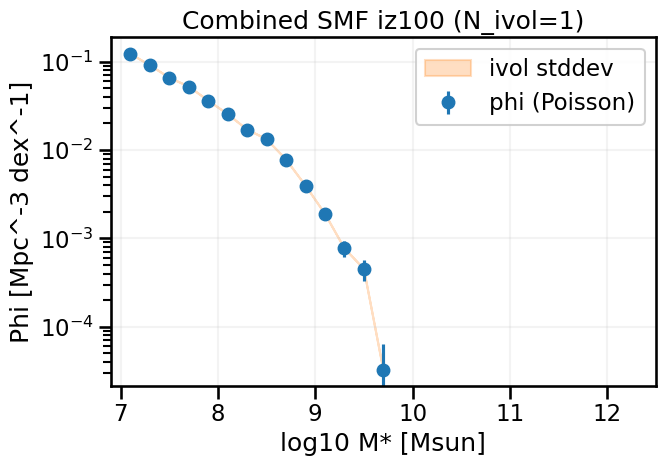

Saved plot to python_oh/results/imf_replication/smf_combined_iz100.png


In [ ]:
# Save IMF plot and data to correct subfolders
plot_dir = 'plots/imf_replication'
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, 'imf_replication.png'), dpi=150, bbox_inches='tight')

data_dir = 'plots/_plots_data/imf_replication'
os.makedirs(data_dir, exist_ok=True)
df = pd.DataFrame({
    'mass': mass,
    'dndm': dndm
})
df.to_csv(os.path.join(data_dir, 'imf_replication.csv'), index=False)

skip /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol1/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
skip /cosma5/data/durham/dc-hick2/Galform_Out/L800/gp14/iz100/ivol2/galaxies.hdf5 Unable to synchronously open file (bad object header version number)
Saved xi table to python_oh/results/imf_replication/xi_combined_iz100.csv


/tmp/ipykernel_1664807/155103415.py:106: RuntimeWarning: divide by zero encountered in divide
  RR_j = (N_j*(N_j-1)/2.0) * (shell_vol / V_j)
/tmp/ipykernel_1664807/155103415.py:106: RuntimeWarning: invalid value encountered in multiply
  RR_j = (N_j*(N_j-1)/2.0) * (shell_vol / V_j)


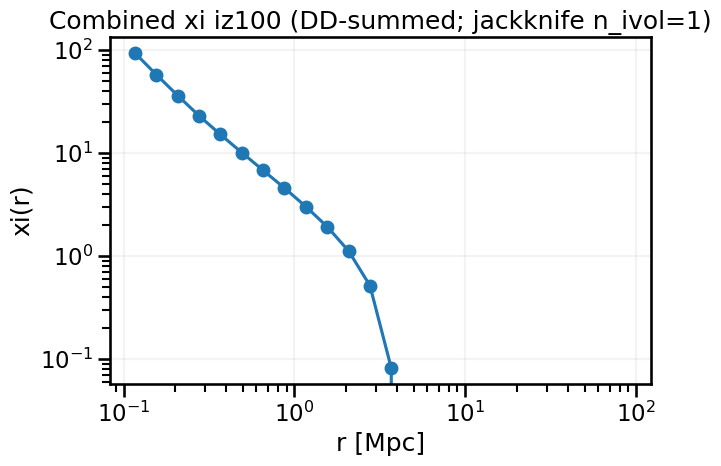

Saved xi plot to python_oh/results/imf_replication/xi_combined_iz100.png


In [ ]:
# 35. Combined correlation function xi(r): sum DD over ivols, analytic RR, and jackknife covariance
"""
import numpy as np
import os
import h5py
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import pandas as pd
Compute pair counts DD per ivol using scipy.spatial.cKDTree (fallback to brute if unavailable), sum DD, compute analytic RR from total N and total volume, and compute xi = DD/RR - 1.
Also compute jackknife samples by leaving out one ivol at a time and derive covariance on xi.
"""

iz = '100'
pattern = os.path.join(L800_ROOT, '**', f'iz{iz}', 'ivol*', 'galaxies.hdf5')
paths = sorted(glob.glob(pattern, recursive=True))
# radial bins
r_edges = np.logspace(-1, 2.0, 25)  # 0.1 to 100 Mpc, adjust if needed
r_centers = 0.5*(r_edges[:-1]+r_edges[1:])

DD_list = []
N_list = []
vol_list = []
valid_paths = []
min_pairs_ivol = 20
for p in paths:
    try:
        with h5py.File(p,'r') as hf:
            # find output
            out = None
            for k in hf.keys():
                if k.lower().startswith('output'):
                    out = hf[k]
                    break
            if out is None:
                continue
            # find coords
            coord_keys = [k for k in out.keys() if k.lower() in ('x','xgal')]
            if not coord_keys:
                # try xgal/ygal/zgal
                if all(k in out for k in ['xgal','ygal','zgal']):
                    x = np.array(out['xgal'])
                    y = np.array(out['ygal'])
                    z = np.array(out['zgal'])
                else:
                    continue
            else:
                x = np.array(out[coord_keys[0]])
                # try y,z neighbors
                y = np.array(out[[k for k in out.keys() if k.lower() in ('y','ygal')][0]]) if any(k.lower() in ('y','ygal') for k in out.keys()) else None
                z = np.array(out[[k for k in out.keys() if k.lower() in ('z','zgal')][0]]) if any(k.lower() in ('z','zgal') for k in out.keys()) else None
                if y is None or z is None:
                    # try explicit names
                    if all(k in out for k in ['xgal','ygal','zgal']):
                        x = np.array(out['xgal'])
                        y = np.array(out['ygal'])
                        z = np.array(out['zgal'])
                    else:
                        continue
            pts = np.column_stack([x,y,z])
            N = pts.shape[0]
            if N < 5:
                continue
            # DD counts via cKDTree
            tree = cKDTree(pts)
            counts = np.zeros(len(r_edges)-1, dtype=np.int64)
            for i in range(len(r_edges)-1):
                lo, hi = r_edges[i], r_edges[i+1]
                # count pairs within hi minus pairs within lo
                counts_hi = tree.count_neighbors(tree, hi)
                counts_lo = tree.count_neighbors(tree, lo)
                # count_neighbors returns number of pairs (i<j)
                counts[i] = counts_hi - counts_lo
            # counts are number of pairs; KDTree returns pairs i<j
            DD_list.append(counts)
            N_list.append(N)
            # volume
            vol = np.nan
            if 'Parameters' in hf:
                for cand in ['volume','volume_Mpc3','Volume']:
                    if cand in hf['Parameters']:
                        try:
                            vol = float(hf['Parameters'][cand][()])
                            break
                        except Exception:
                            pass
            vol_list.append(vol)
            valid_paths.append(p)
    except Exception as e:
        print('skip', p, e)

if not DD_list:
    print('No valid ivols with coordinates found; cannot compute xi')
else:
    DD_arr = np.array(DD_list)
    DD_total = DD_arr.sum(axis=0)
    N_total = np.sum(N_list)
    V_total = np.nansum([v for v in vol_list if not np.isnan(v)])
    # analytic RR estimate: expected pairs in shell = N*(N-1)/2 * shell_volume / V_total
    shell_vol = 4.0/3.0 * np.pi * (r_edges[1:]**3 - r_edges[:-1]**3)
    RR_total = (N_total*(N_total-1)/2.0) * (shell_vol / V_total)
    # avoid zero
    xi = DD_total / RR_total - 1.0

    # Jackknife: leave-one-out
    JK_xis = []
    n_jk = len(DD_arr)
    for j in range(n_jk):
        DD_j = np.sum(np.delete(DD_arr, j, axis=0), axis=0)
        N_j = np.sum(np.delete(np.array(N_list), j))
        V_j = np.nansum(np.delete(np.array(vol_list), j)[~np.isnan(np.delete(np.array(vol_list), j))])
        RR_j = (N_j*(N_j-1)/2.0) * (shell_vol / V_j)
        xi_j = DD_j / RR_j - 1.0
        JK_xis.append(xi_j)
    JK_xis = np.vstack(JK_xis)
    xi_mean_jk = JK_xis.mean(axis=0)
    # jackknife covariance
    cov = (n_jk-1)/n_jk * ((JK_xis - xi_mean_jk).T @ (JK_xis - xi_mean_jk))
    jk_err = np.sqrt(np.diag(cov))

    # Save results
    dfxi = pd.DataFrame({'r': r_centers, 'xi': xi, 'xi_jk_err': jk_err, 'DD': DD_total, 'RR': RR_total})
    out_csv = os.path.join(RESULTS_DIR, f'xi_combined_iz{iz}.csv')
    dfxi.to_csv(out_csv, index=False)
    print('Saved xi table to', out_csv)

    # Plot xi with jackknife errors
    plt.figure(figsize=(7,5))
    plt.errorbar(r_centers, xi, yerr=jk_err, fmt='o-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [Mpc]')
    plt.ylabel('xi(r)')
    plt.title(f'Combined xi iz{iz} (DD-summed jackknife n_ivol={n_jk})')
    out_png = os.path.join(RESULTS_DIR, f'xi_combined_iz{iz}.png')
    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    plt.show()
    print('Saved xi plot to', out_png)
